# ToDo
after meeting march 24
- purterb after line 9, instead of before. then it is truly zero just before i save it
- purterb S_EVO so i can watch the purturb propogate through that as well
- run casp 15 proteins (they are harder). Talk to sachin about them. he has their alignments
- save pdb so i can get tmscore out of these
- use tmscore with ground truth instead
- use different similarity metric for 'positions'. cosine does not make sense here.
- purturb Z inside the struct module

In [108]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle

In [109]:
LATENTSPACE_UNPERTURBED = "../data/taccruns/predictions-latentspacesave1-unperturbed/"#"../data/taccruns/predictions-latentspace-unperturbed/"
DOE_7bcz_A = "../data/taccruns/predictions-latentspacesave-DOEstrucmodu_7bcz_A/" #
DOE_STRUCT_MODU = "../data/taccruns/predictions-latentspacesave-DOE_struct_modu/"

In [110]:
# cameo dict
with open('cameo_dict.pkl', 'rb') as f: cameo_dict = pickle.load(f)
stats = ['tmscore_model1','tmscore_model4','tmscore_model1_1iter',
         'tmscore_model1_struc_modu_s0firstblock_1iter','tmscore_model1_struc_modu_s0firstblock',
         'tmscore_model1_s0_after_struc_modu']


In [114]:
#lst_iterations = [f"r{r}i{i}" for r in range(4) for i in range(8)]
lst_iterations = [f"i{i}" for r in range(4) for i in range(8)]
lst_iterations[0] = "r0 i0"
lst_iterations[8] = "r1 i0"
lst_iterations[16] = "r2 i0"
lst_iterations[24] = "r3 i0"
#lst_iterations = ['evo'] + lst_iterations

def tmscore_barchart(protein):
    tmscore_stats = []
    for stat in stats:
        tmscore_stats.append(cameo_dict[protein][stat])
    wrapped_labels = [ label.replace('_', '\n') for label in stats ]
    ax = sns.barplot(x=wrapped_labels,y=tmscore_stats)
    ax.set_title(protein)
    #plt.show()
cos = nn.CosineSimilarity(dim=0)


def latent_space_cosine_grid_DOE(protein,rep,i_zeroed,r_zeroed):
    data = np.empty([32,32]) 
    for r1 in range(4):
        for i1 in range(8):
            for r2 in range(4):
                for i2 in range(8):
                    file_1 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1) + '_recy_' + str(r1) + '_.pt'
                    file_2 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i2) + '_recy_' + str(r2) + '_.pt'
                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*8)+i1, (r2*8)+i2] = cos(t1,t2)
    ax = sns.heatmap(data, xticklabels = lst_iterations, yticklabels = lst_iterations, annot=False)
    ax.invert_yaxis()
    ax.set_title(protein + f' | latent space: {rep} | purturbed at i {i_zeroed} r {r_zeroed}\n' + 'recycle (r) structure module iteration (i)' )
    plt.xlabel('Perturbed')
    plt.ylabel('Perturbed')
    #plt.show()
def latent_space_cosine_grid_DOE_with_evo_s(protein,i_zeroed,r_zeroed):
    rep = 's' # required
    lst_iterations_evo = np.insert(lst_iterations,24,'s_evo')
    lst_iterations_evo = np.insert(lst_iterations_evo,16,'s_evo')
    lst_iterations_evo = np.insert(lst_iterations_evo,8,'s_evo')
    lst_iterations_evo = np.insert(lst_iterations_evo,0,'s_evo')
    data = np.zeros([36,36]) 
    for r1 in range(4):
        for i1 in range(9):
            for r2 in range(4):
                for i2 in range(9):
                    if i1 == 0: 
                        file_1 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_evo_block_recy_{r1}_.pt"
                    else:
                        file_1 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1-1) + '_recy_' + str(r1) + '_.pt'
                    if i2 == 0: 
                        file_2 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_evo_block_recy_{r2}_.pt"
                    else:
                        file_2 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i2-1) + '_recy_' + str(r2) + '_.pt'

                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*9)+i1, (r2*9)+i2] = cos(t1,t2)
    ax = sns.heatmap(data, xticklabels = lst_iterations_evo, yticklabels = lst_iterations_evo, annot=False)
    ax.invert_yaxis()
    ax.set_title(protein + f' | latent space: {rep} | purturbed at i {i_zeroed} r {r_zeroed}\n' + 'recycle (r) structure module iteration (i)' )
    plt.xlabel('Perturbed')
    plt.ylabel('Perturbed')
    #plt.show()
def heatmap_pert_vs_unpert(protein,rep,i_zeroed,r_zeroed):
    # WARNING
    # I don't think this is an 
    # accurate representation of 
    # what i'm trying to understand...
    data = np.empty([32,32]) 
    for r1 in range(4):
        for i1 in range(8):
            for r2 in range(4):
                for i2 in range(8):
                    file_1 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1) + '_recy_' + str(r1) + '_.pt'
                    file_2 = DOE_STRUCT_MODU + protein + f'_lspace_zeroedat_r_{-1}_i_{-1}/' + rep + '_iter_' + str(i2) + '_recy_' + str(r2) + '_.pt'
                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*8)+i1, (r2*8)+i2] = cos(t1,t2)
    ax = sns.heatmap(data, xticklabels = lst_iterations, yticklabels = lst_iterations, annot=False)
    ax.invert_yaxis()
    ax.set_title(protein + f' | latent space: {rep} \n unperturbed VS purturbed at i {i_zeroed} r {r_zeroed}' )
    plt.xlabel('Perturbed')
    plt.ylabel('Unperturbed')
    #plt.show()

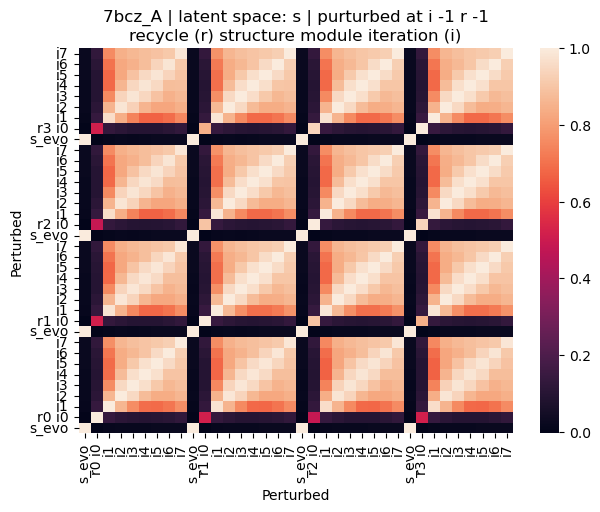

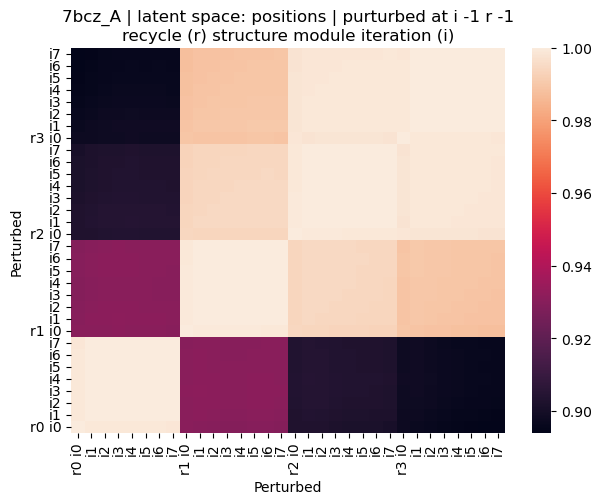

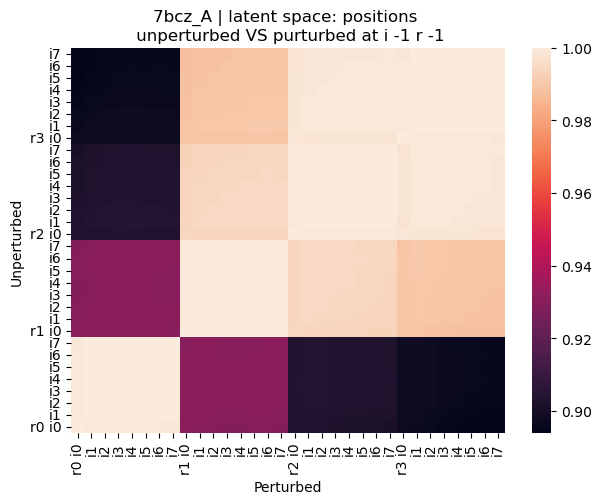

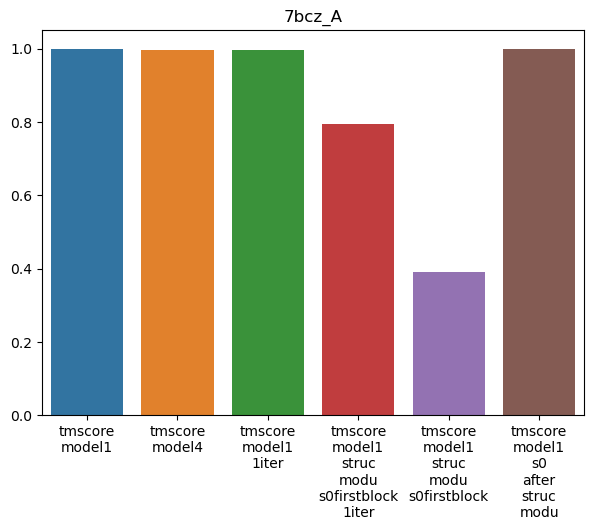

In [115]:
p = '7bcz_A'
plt.rcParams["figure.figsize"] = (7,5)
latent_space_cosine_grid_DOE_with_evo_s(p,-1,-1)
plt.show()
latent_space_cosine_grid_DOE(p,'positions',-1,-1)
plt.show()
#heatmap_pert_vs_unpert(p,'positions',-1,-1)
#plt.show()
tmscore_barchart(p)
plt.show()

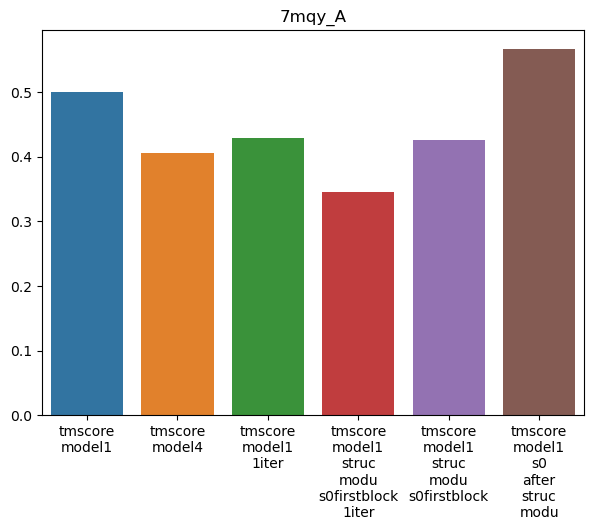

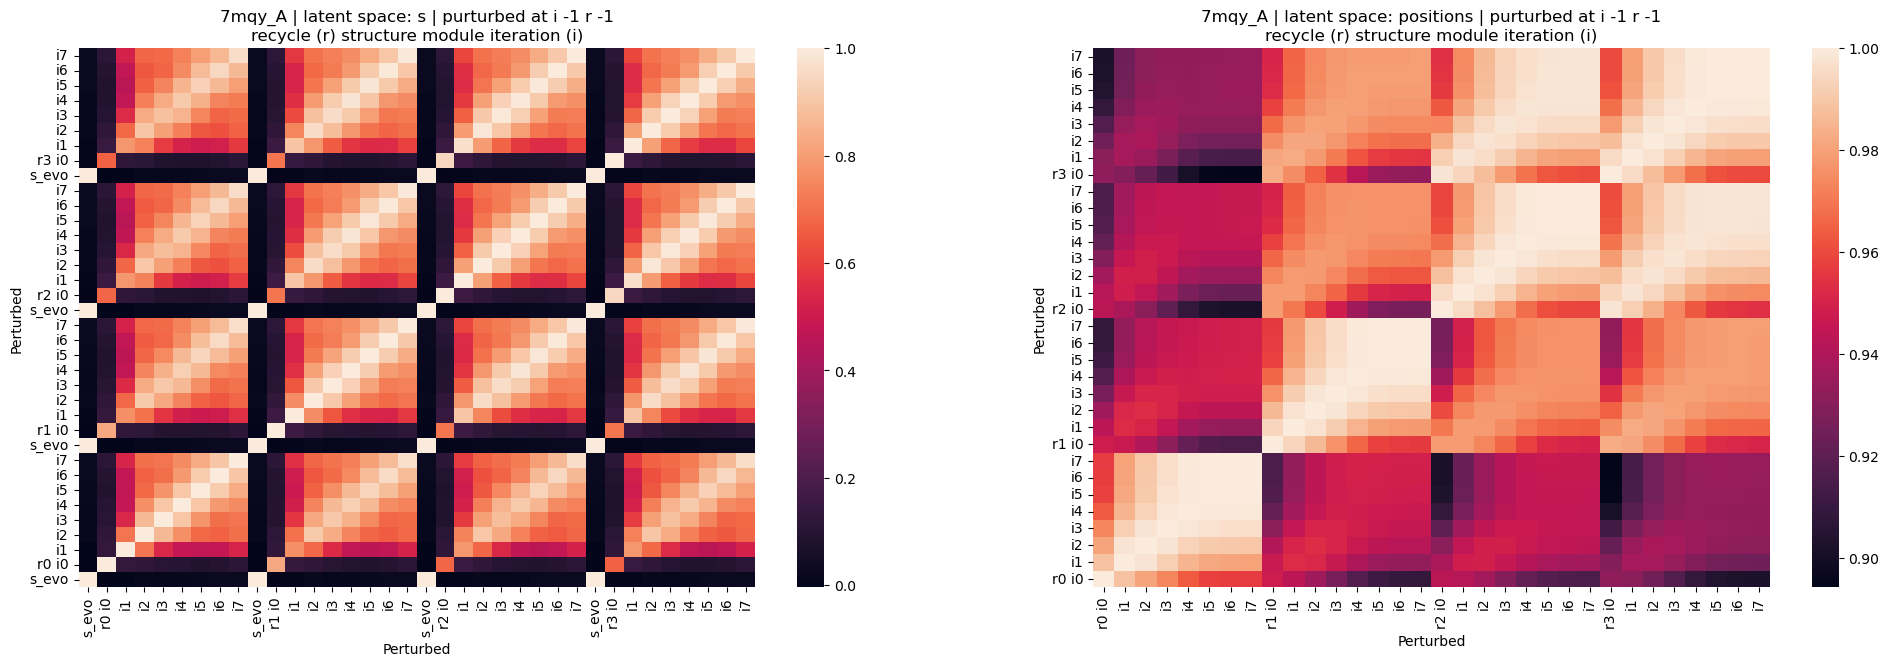

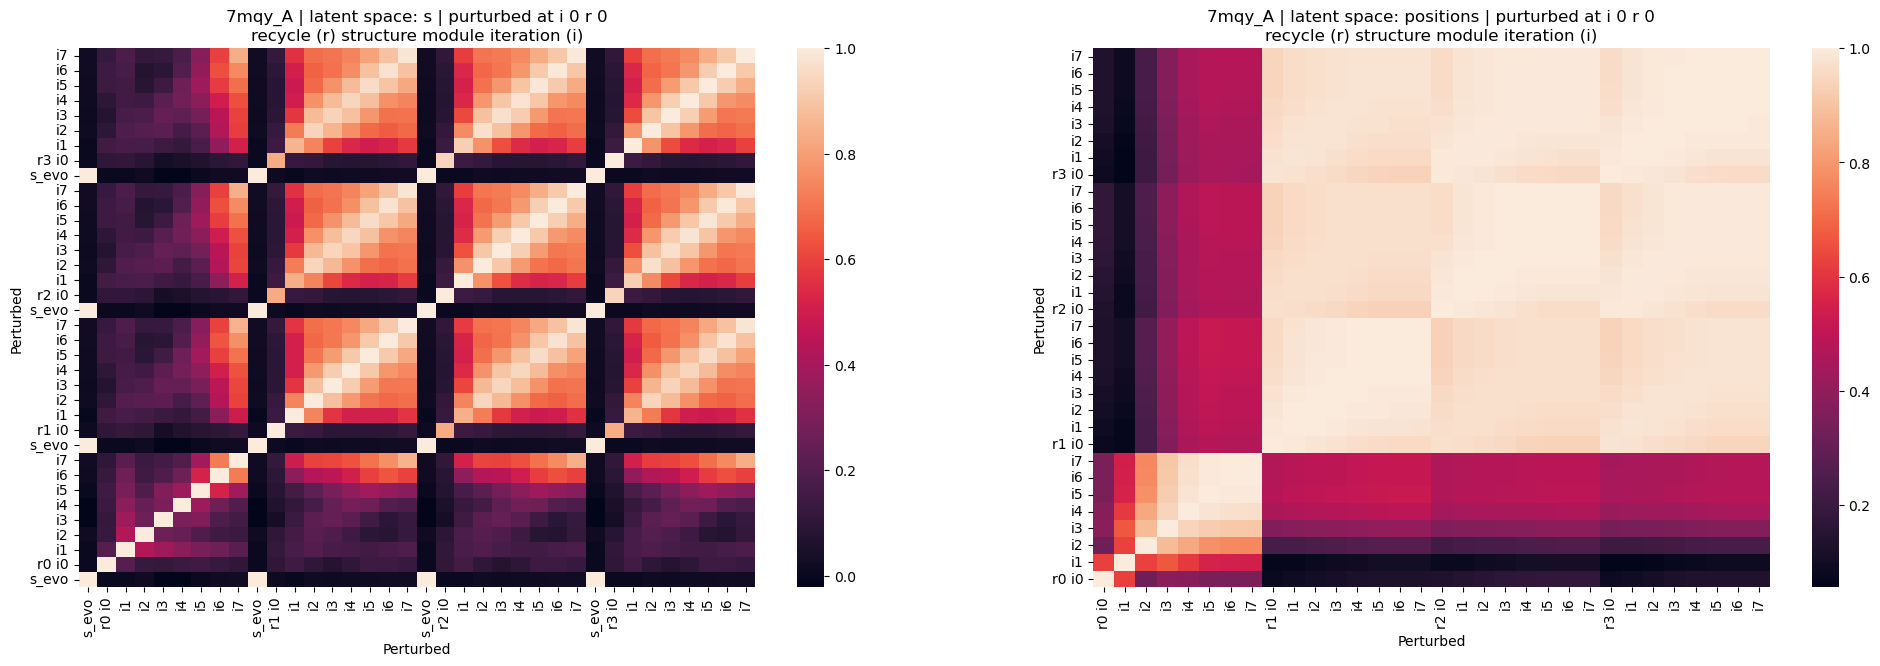

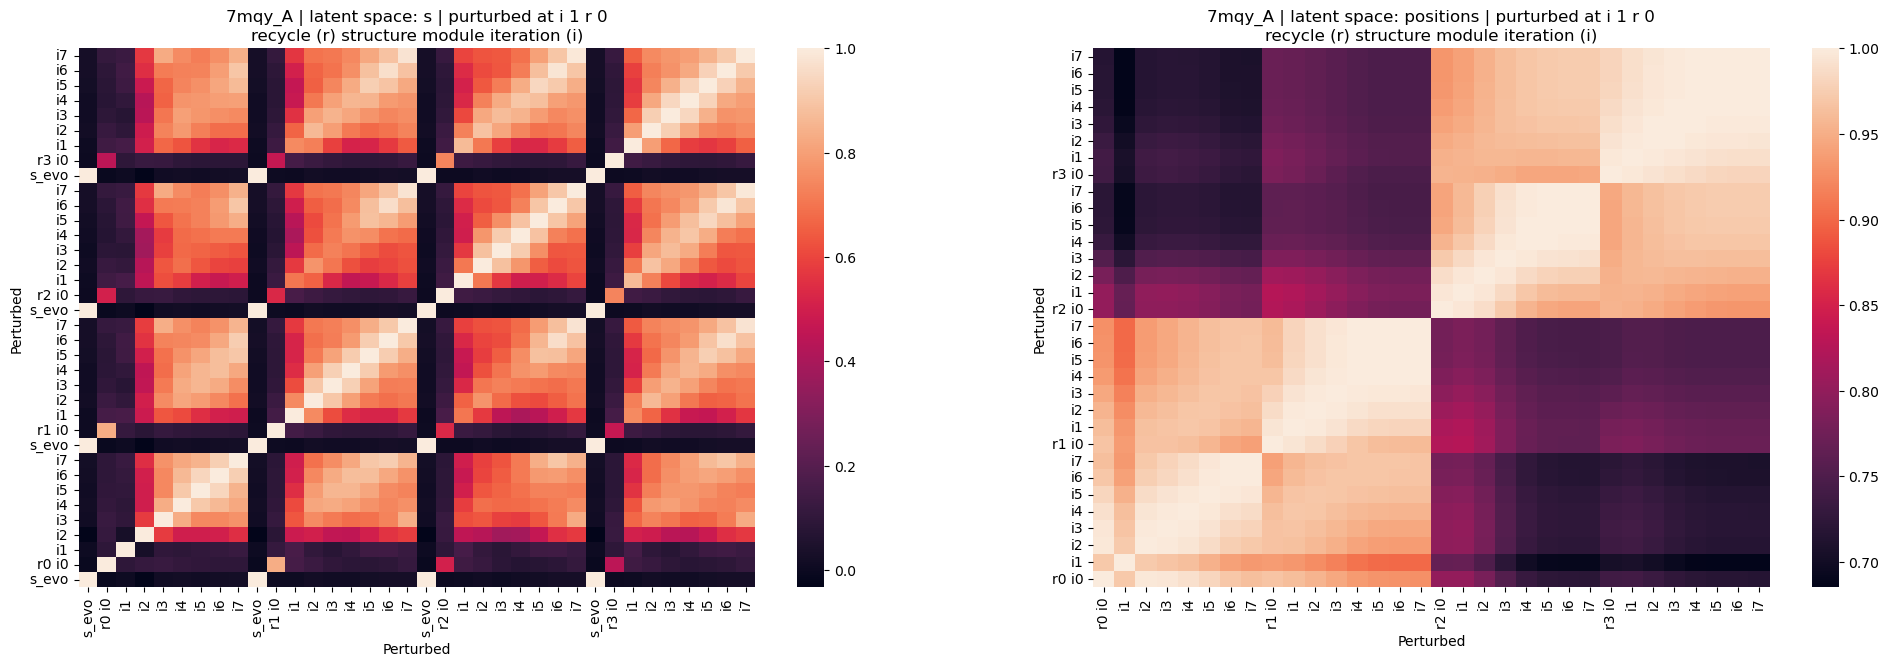

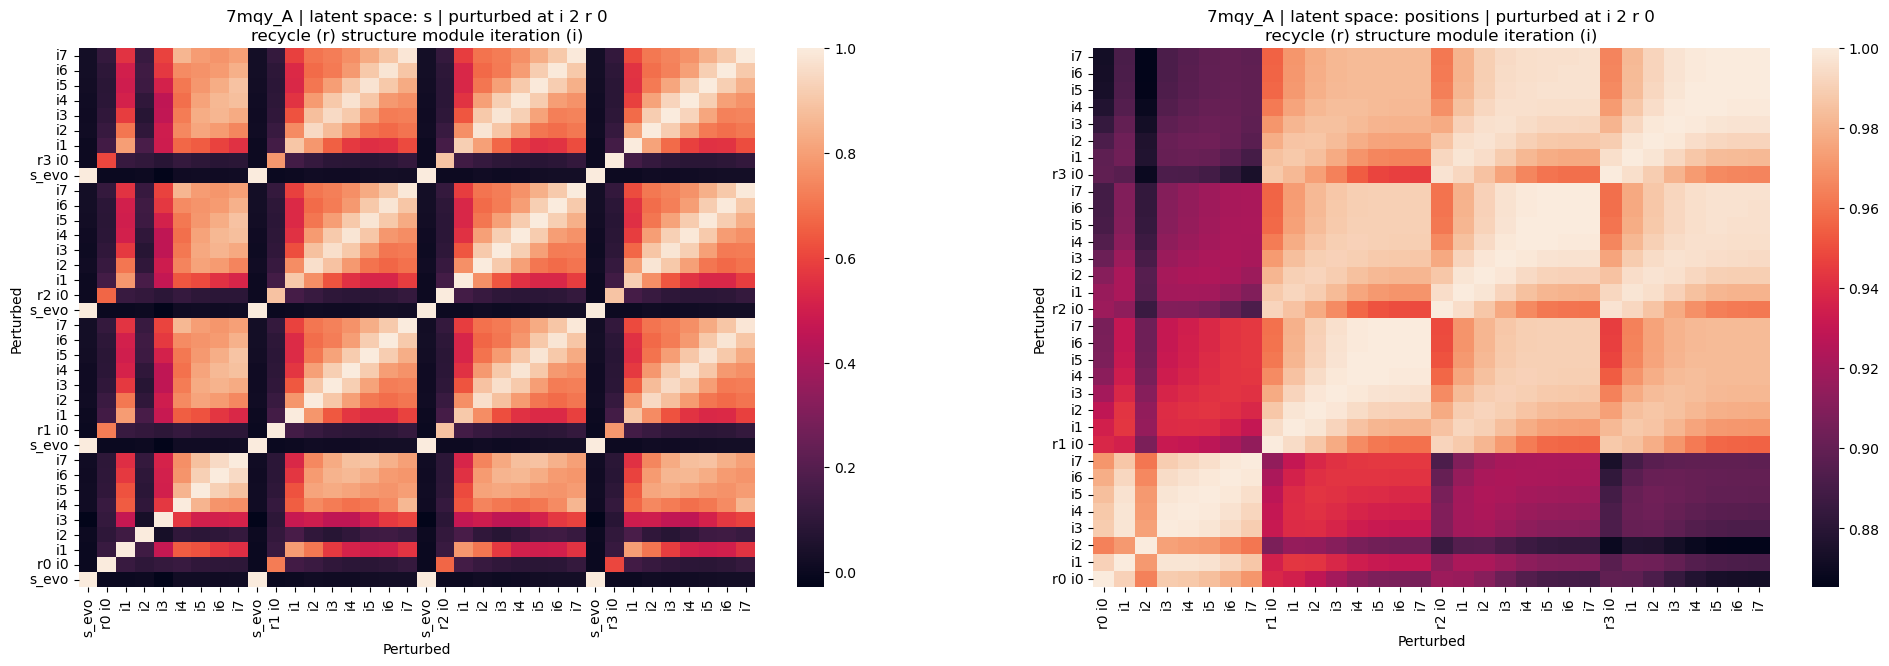

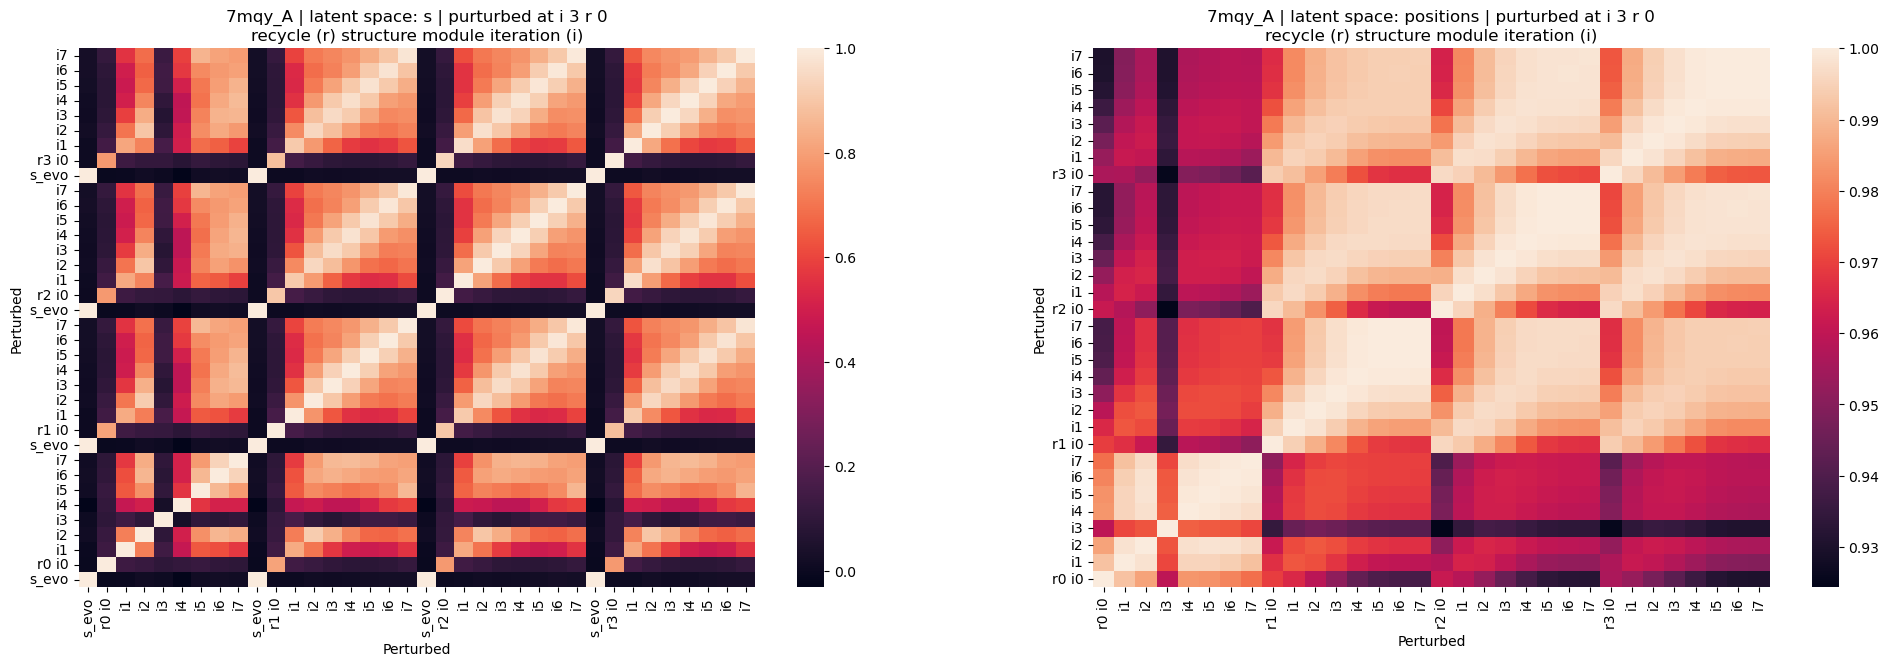

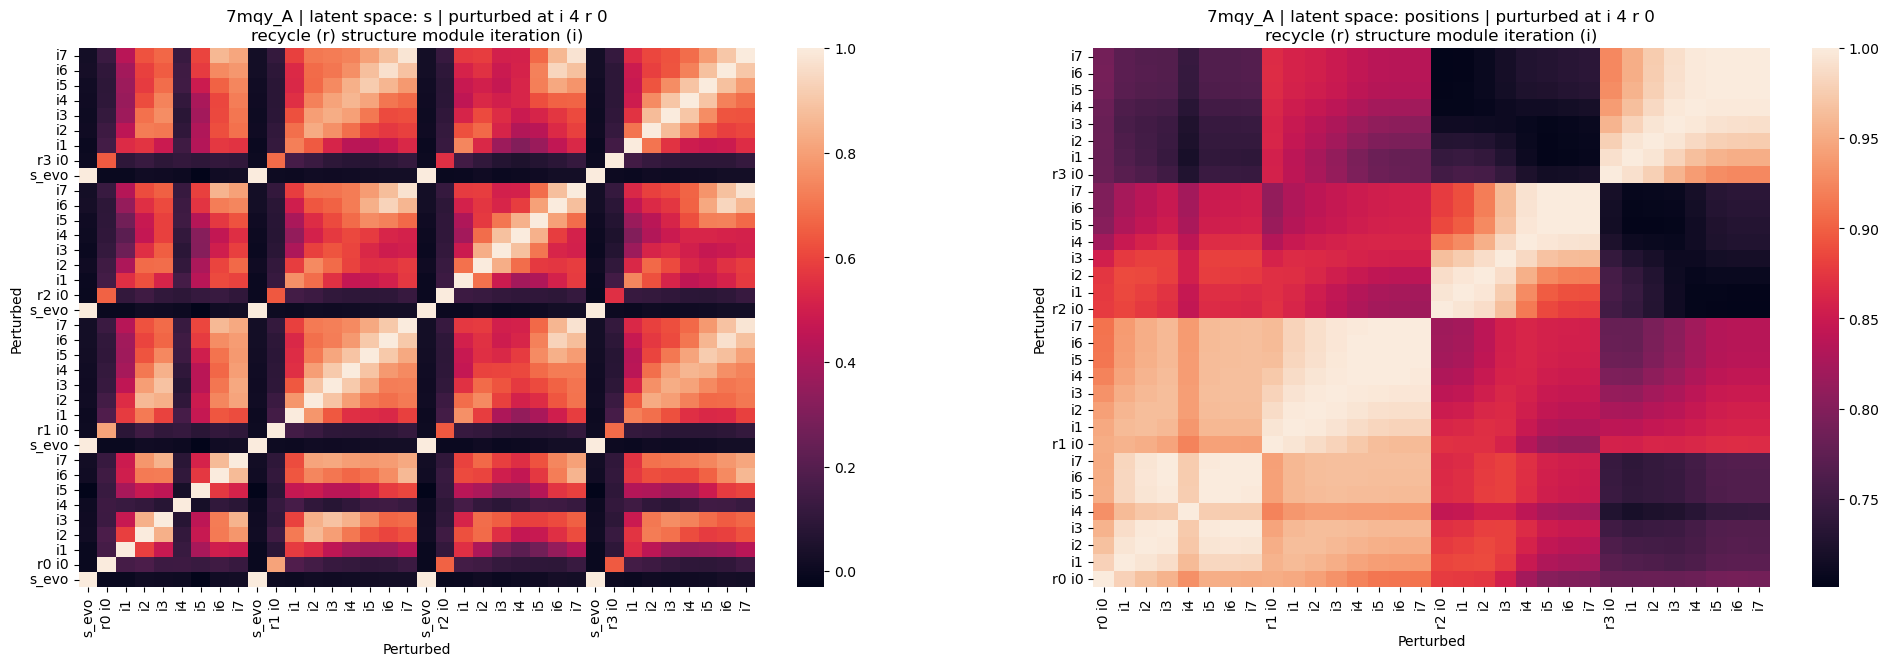

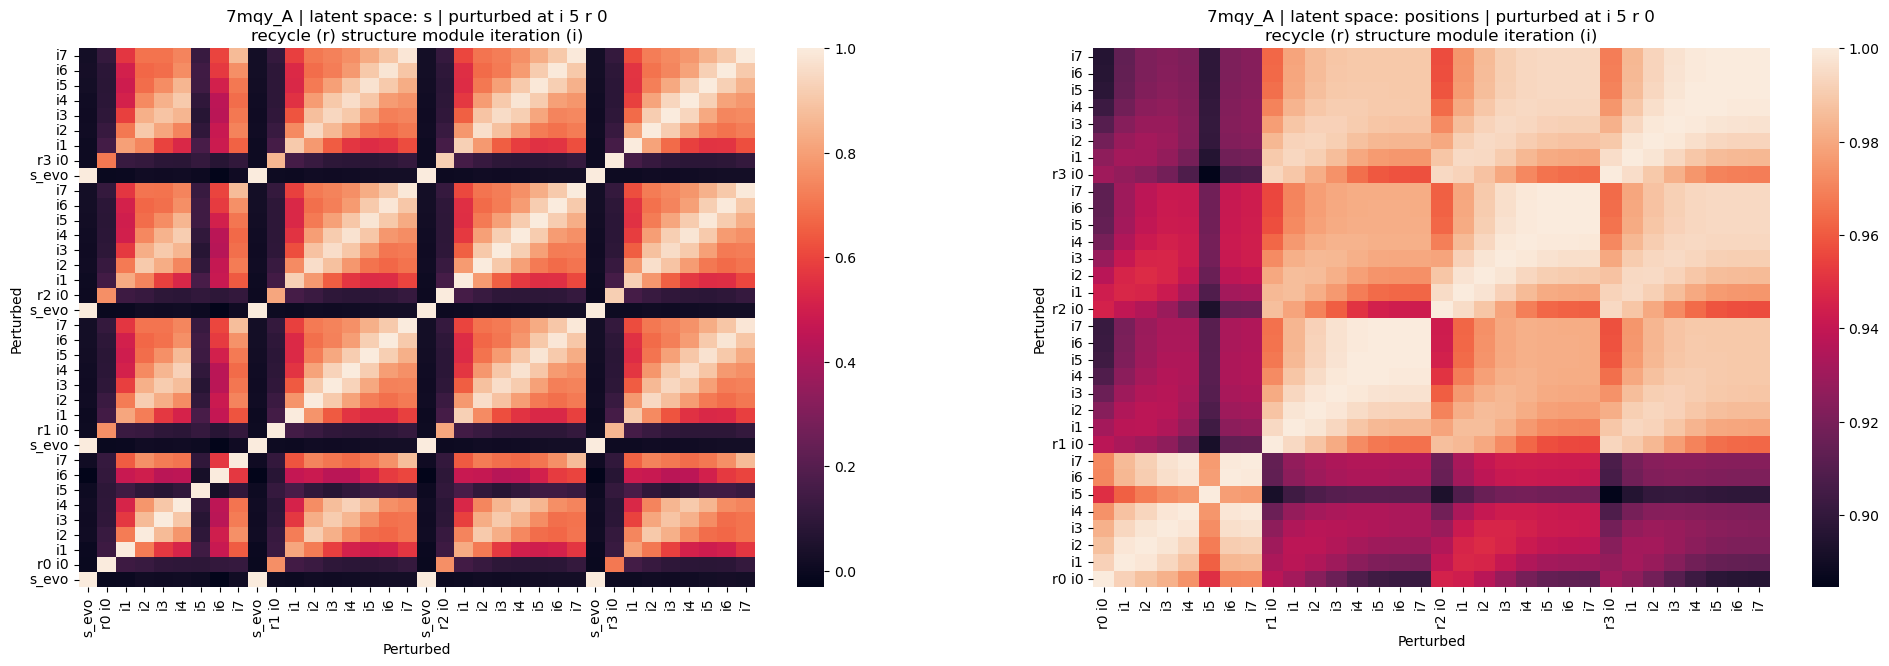

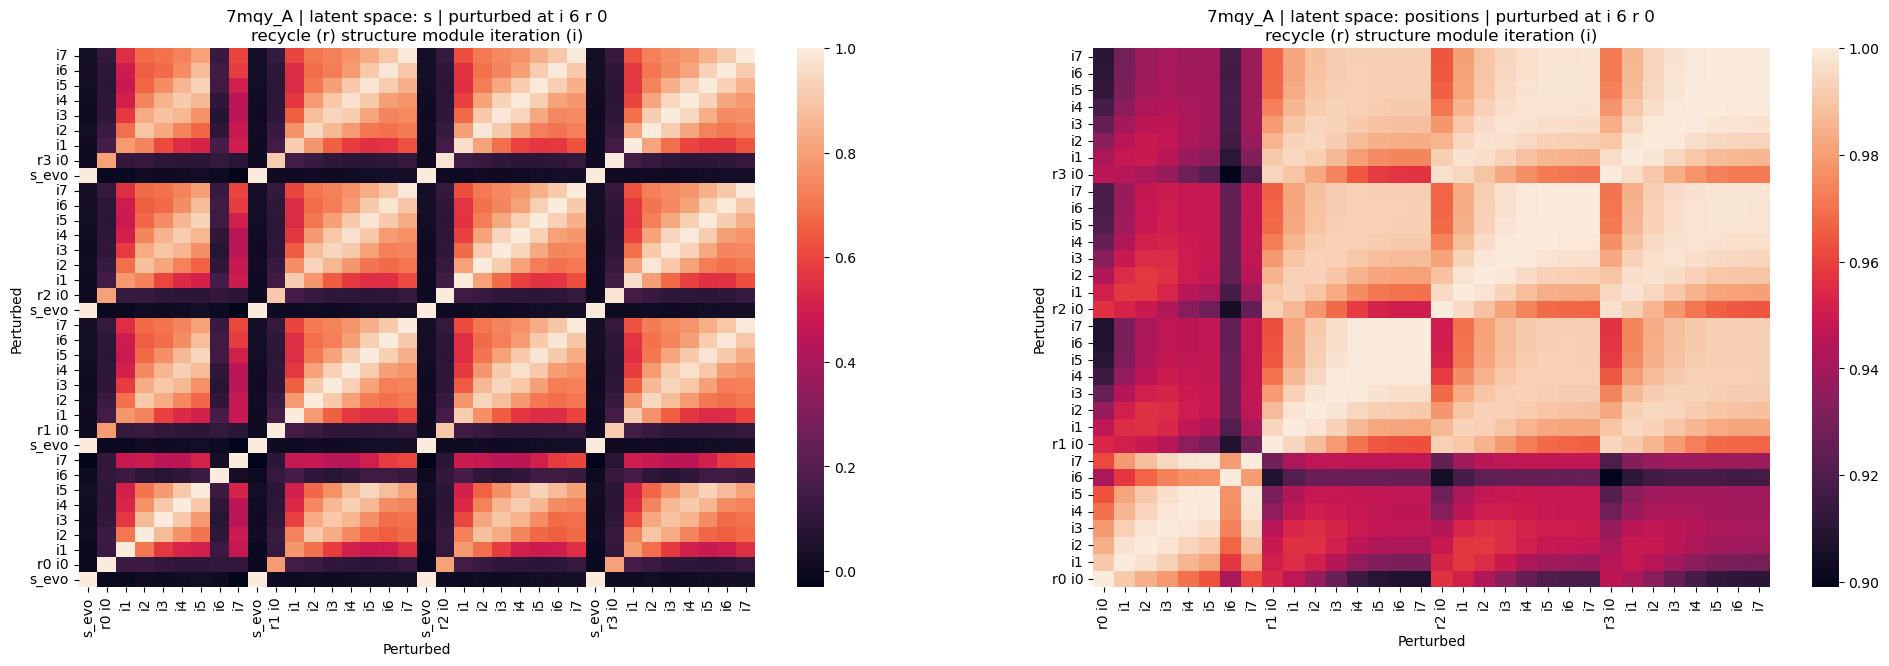

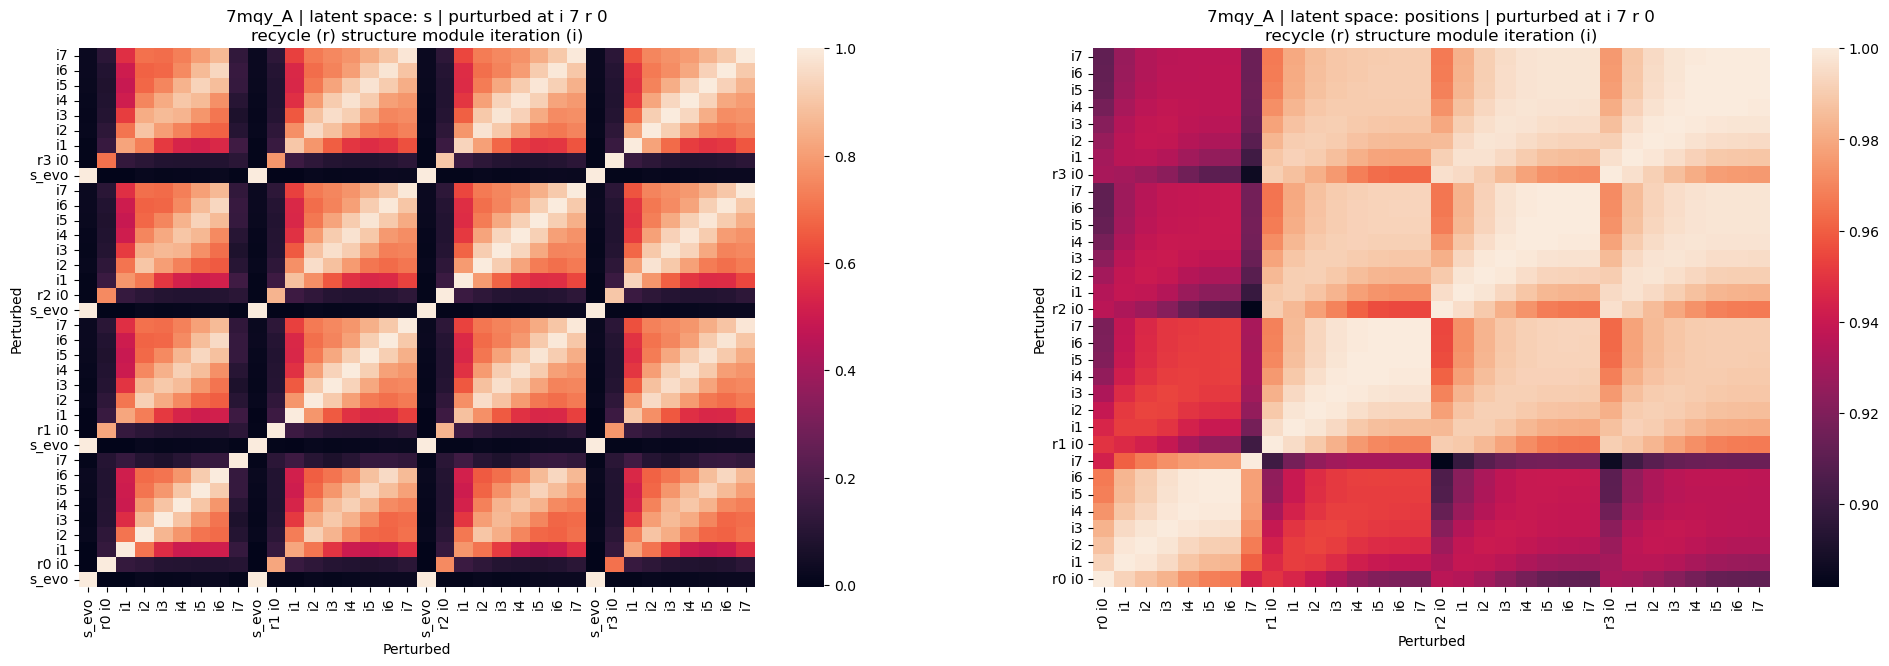

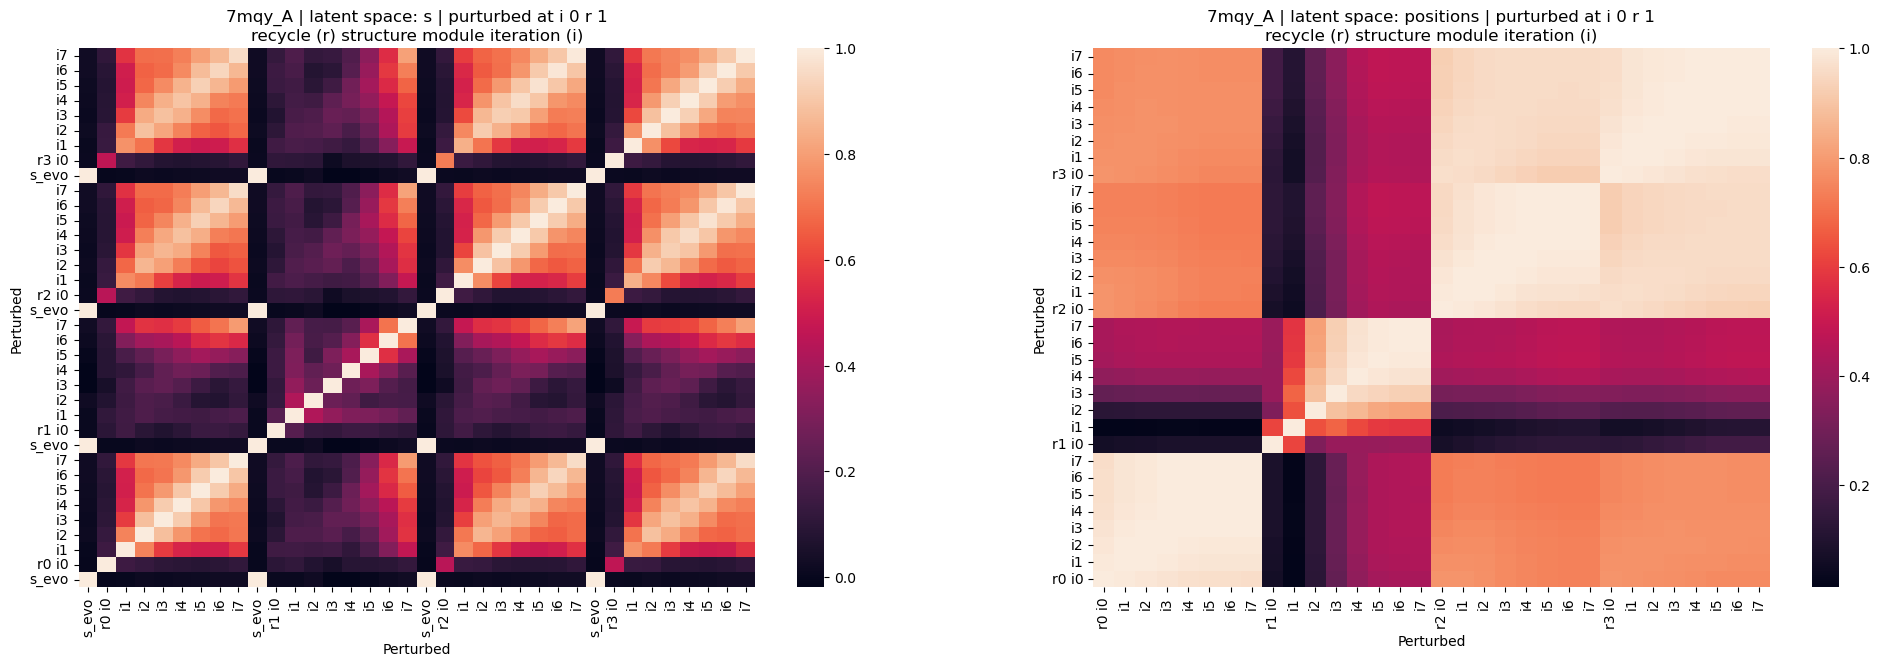

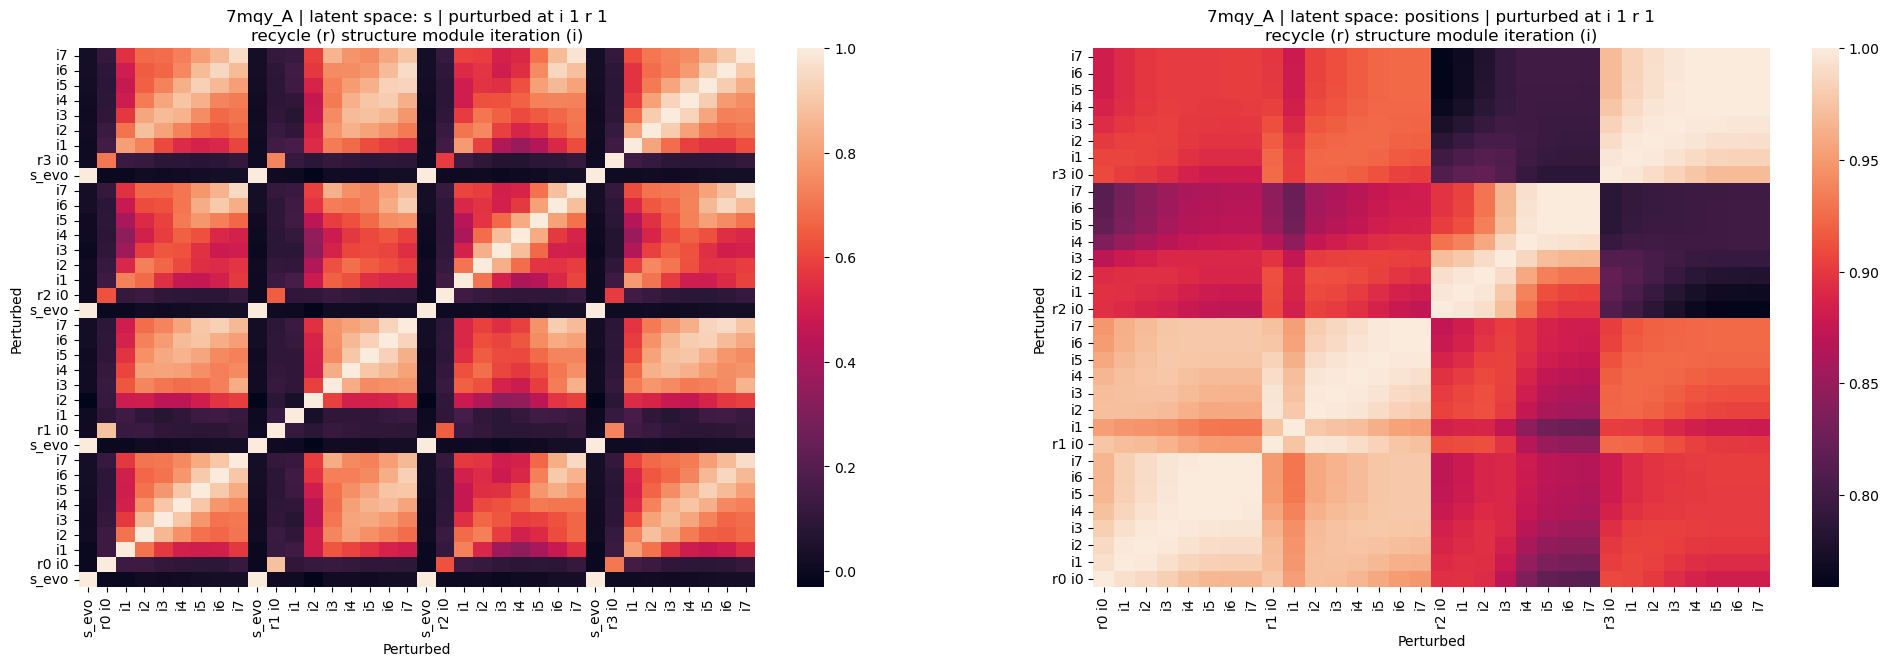

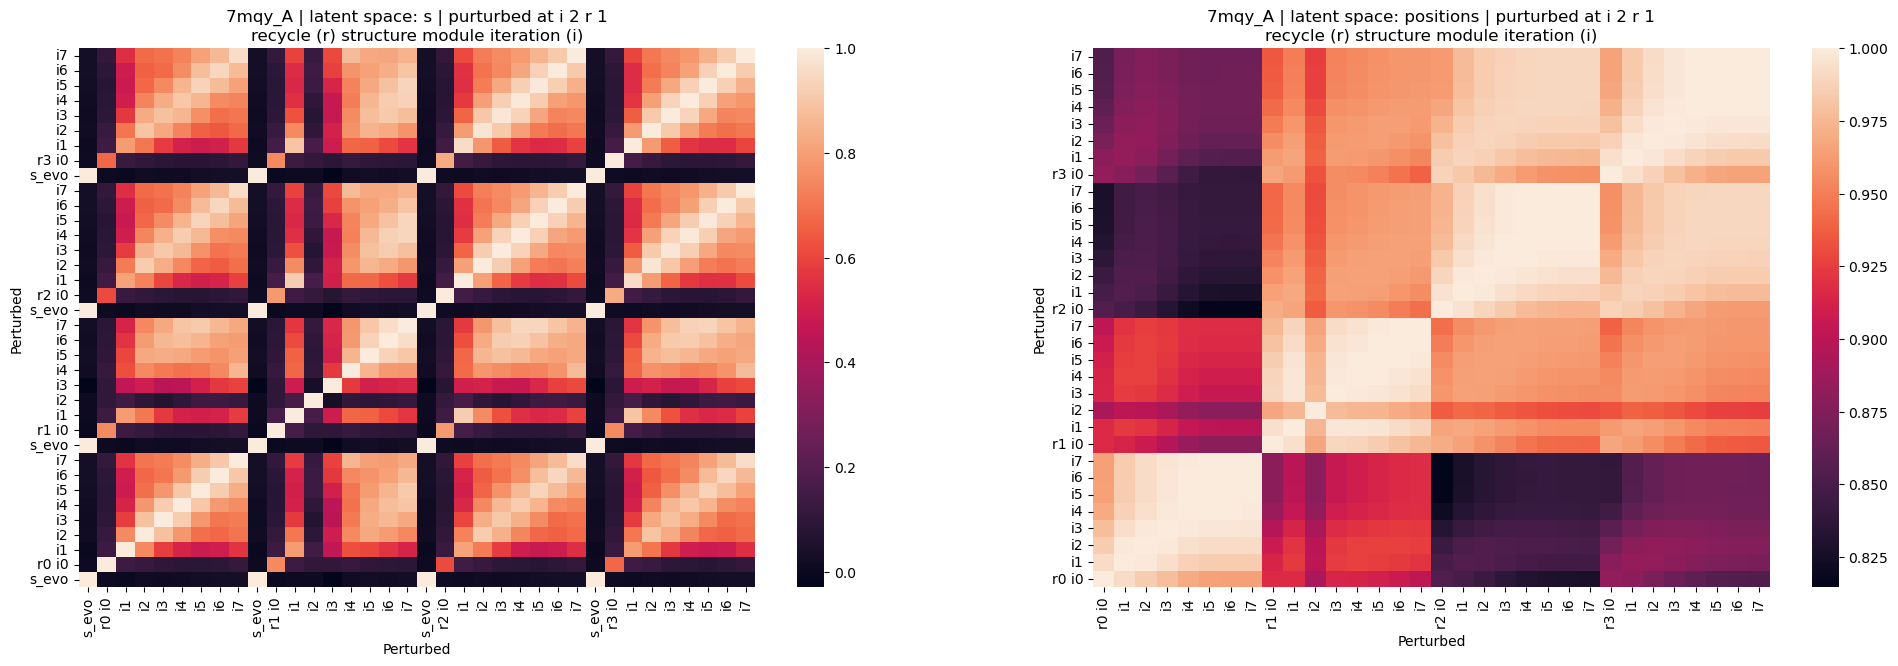

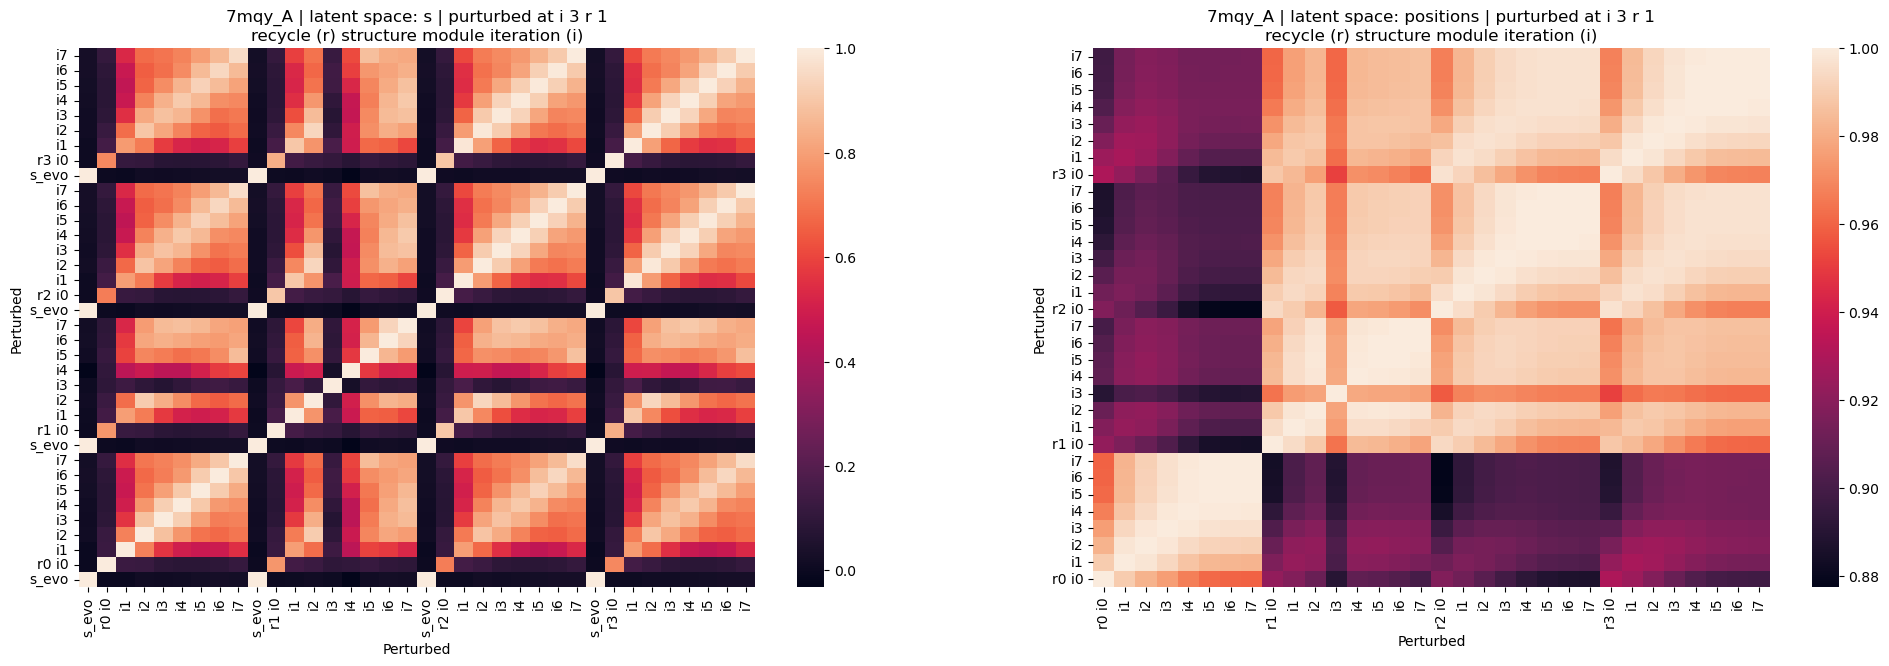

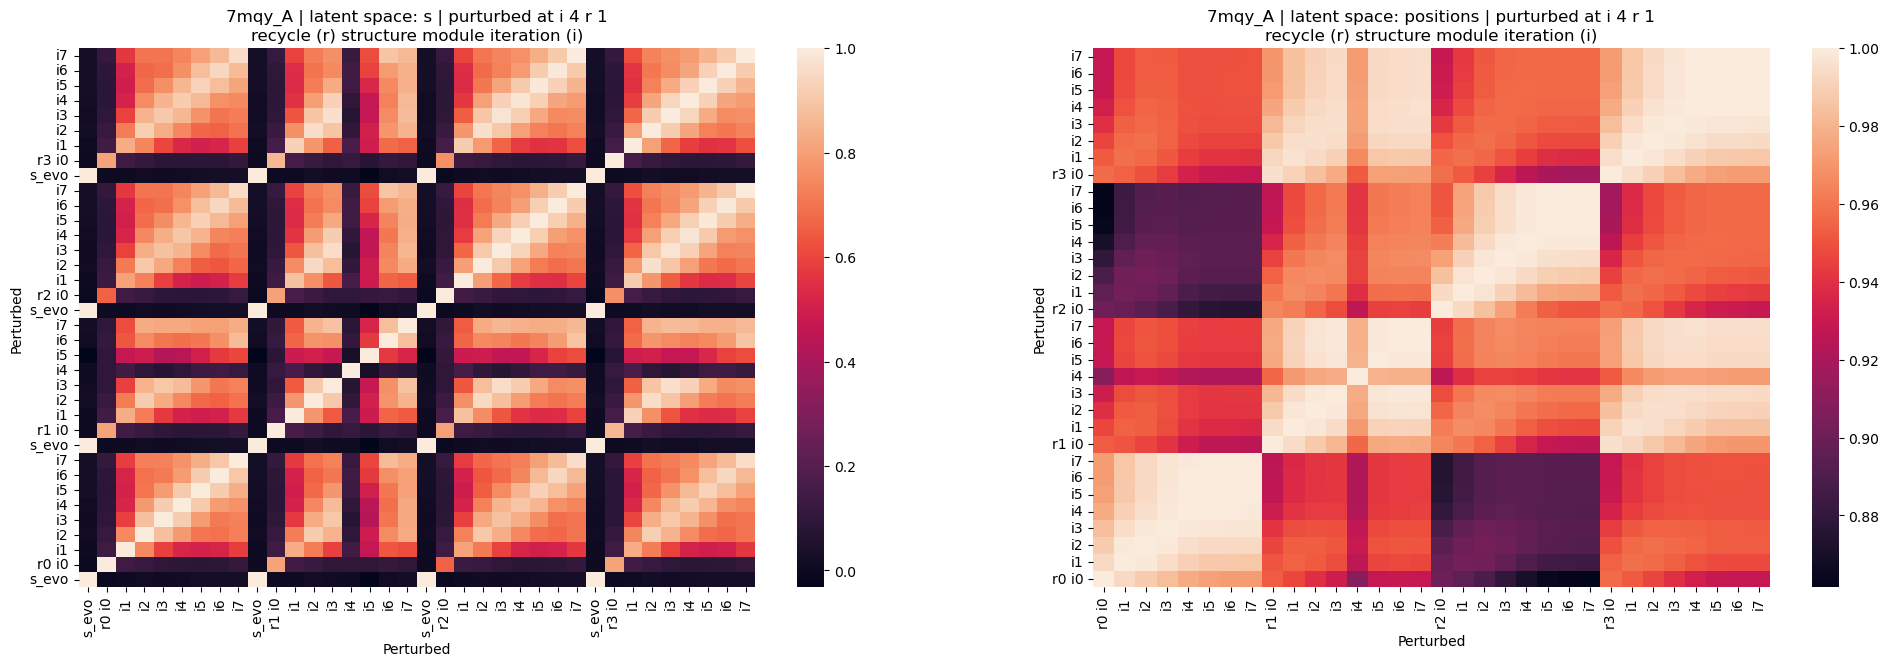

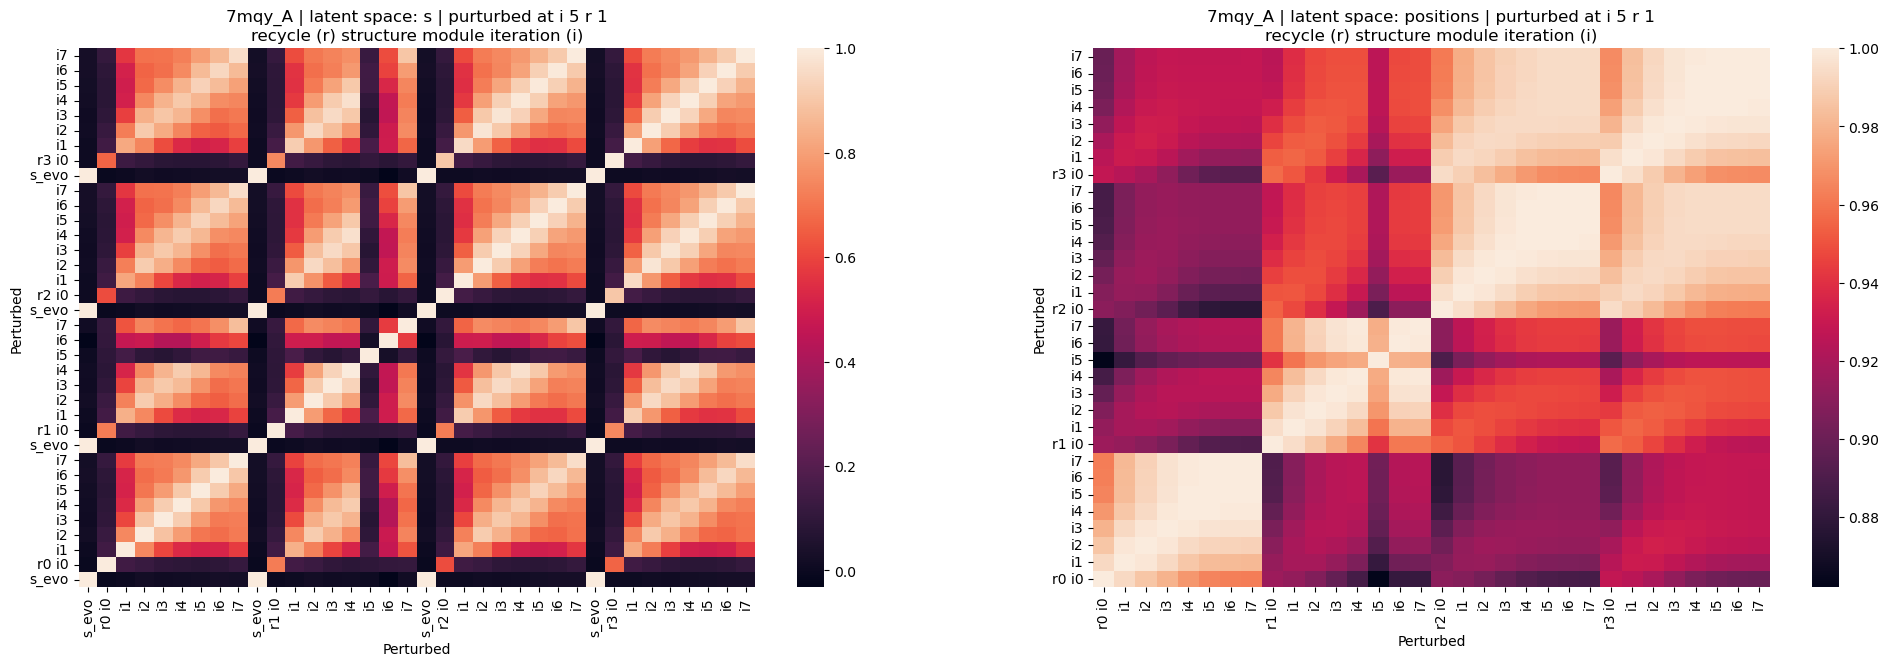

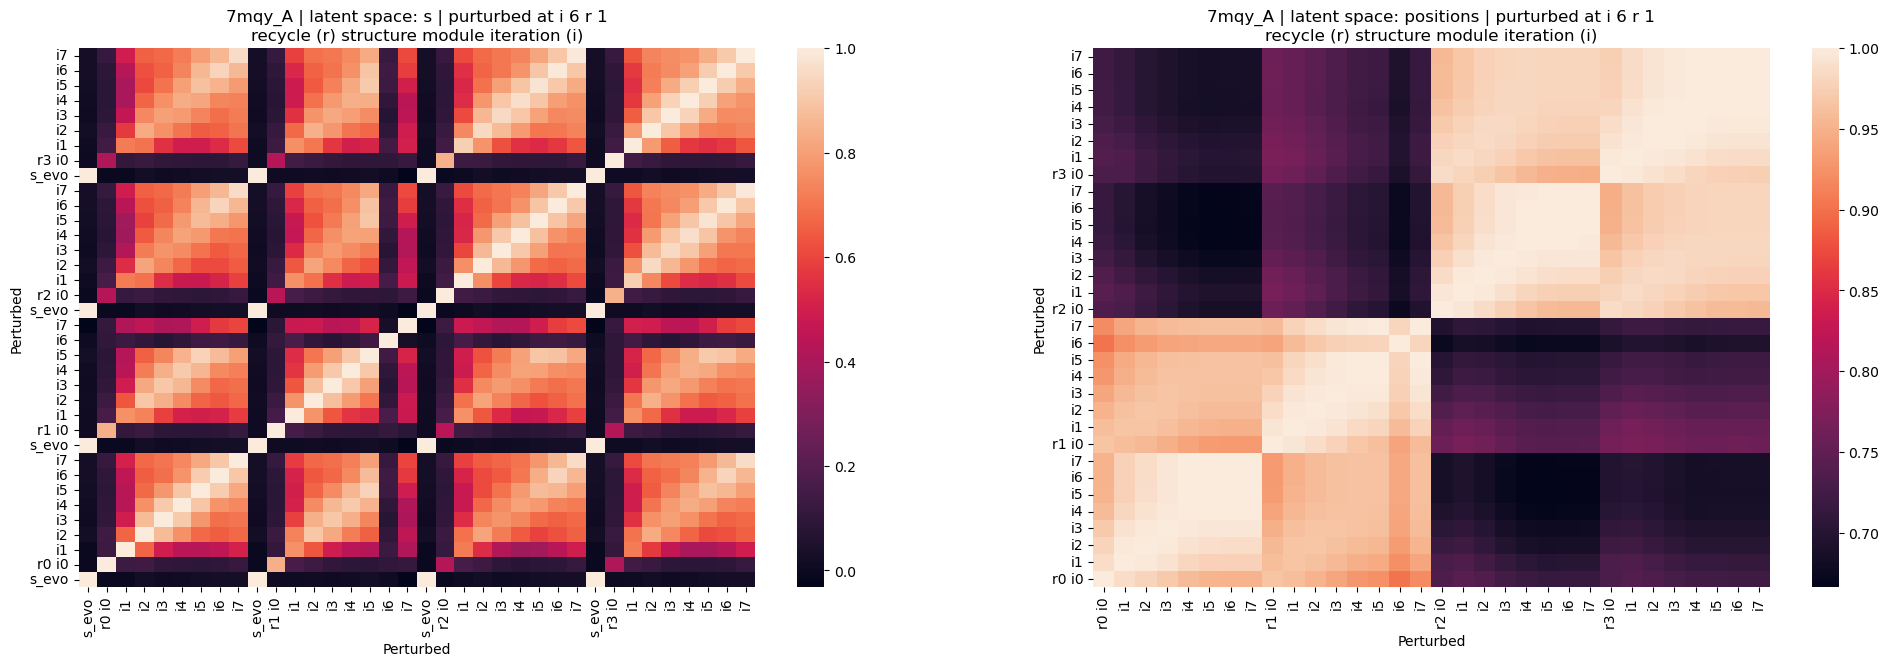

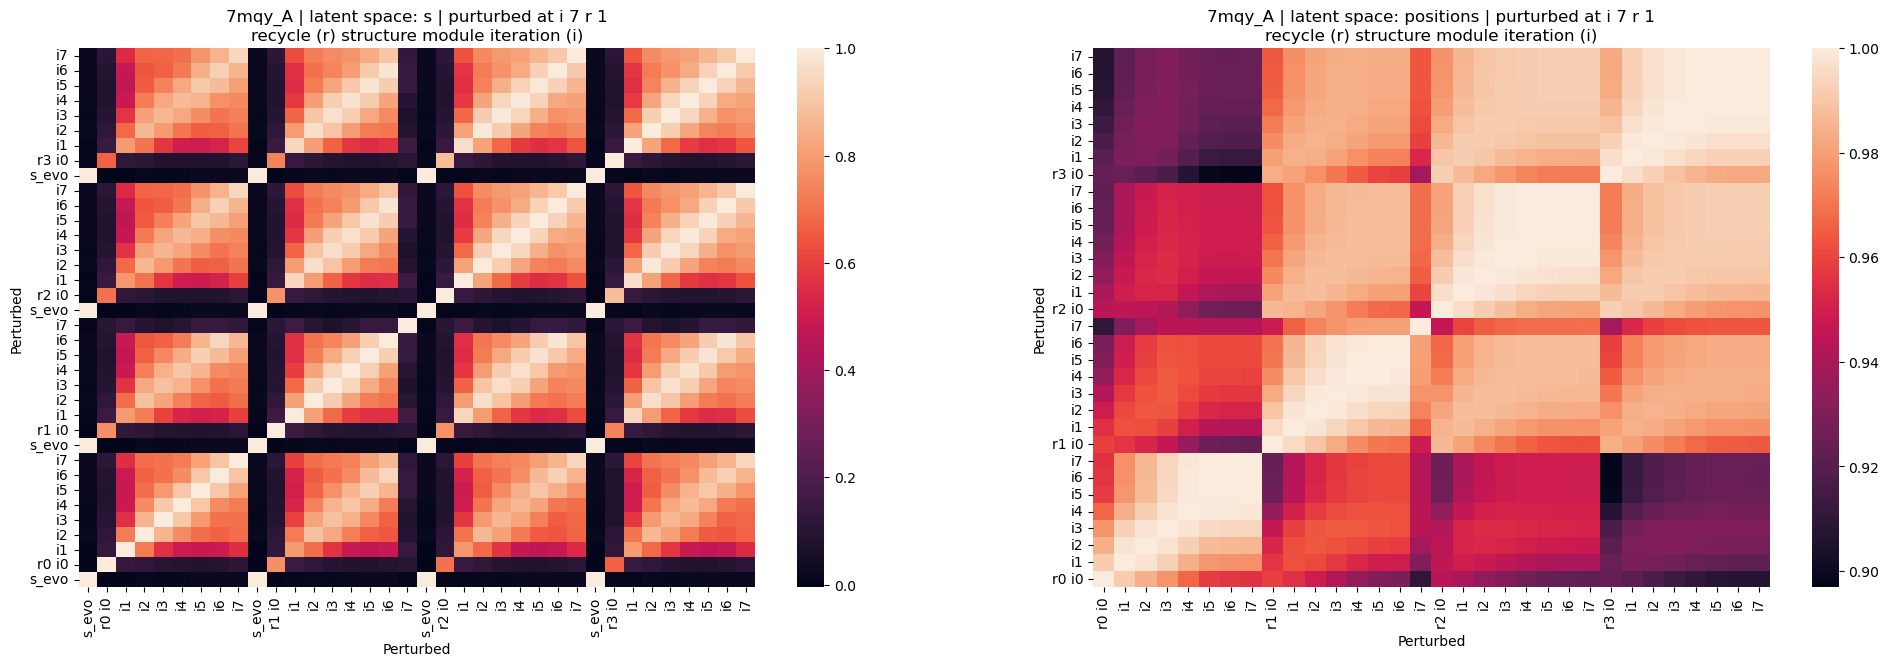

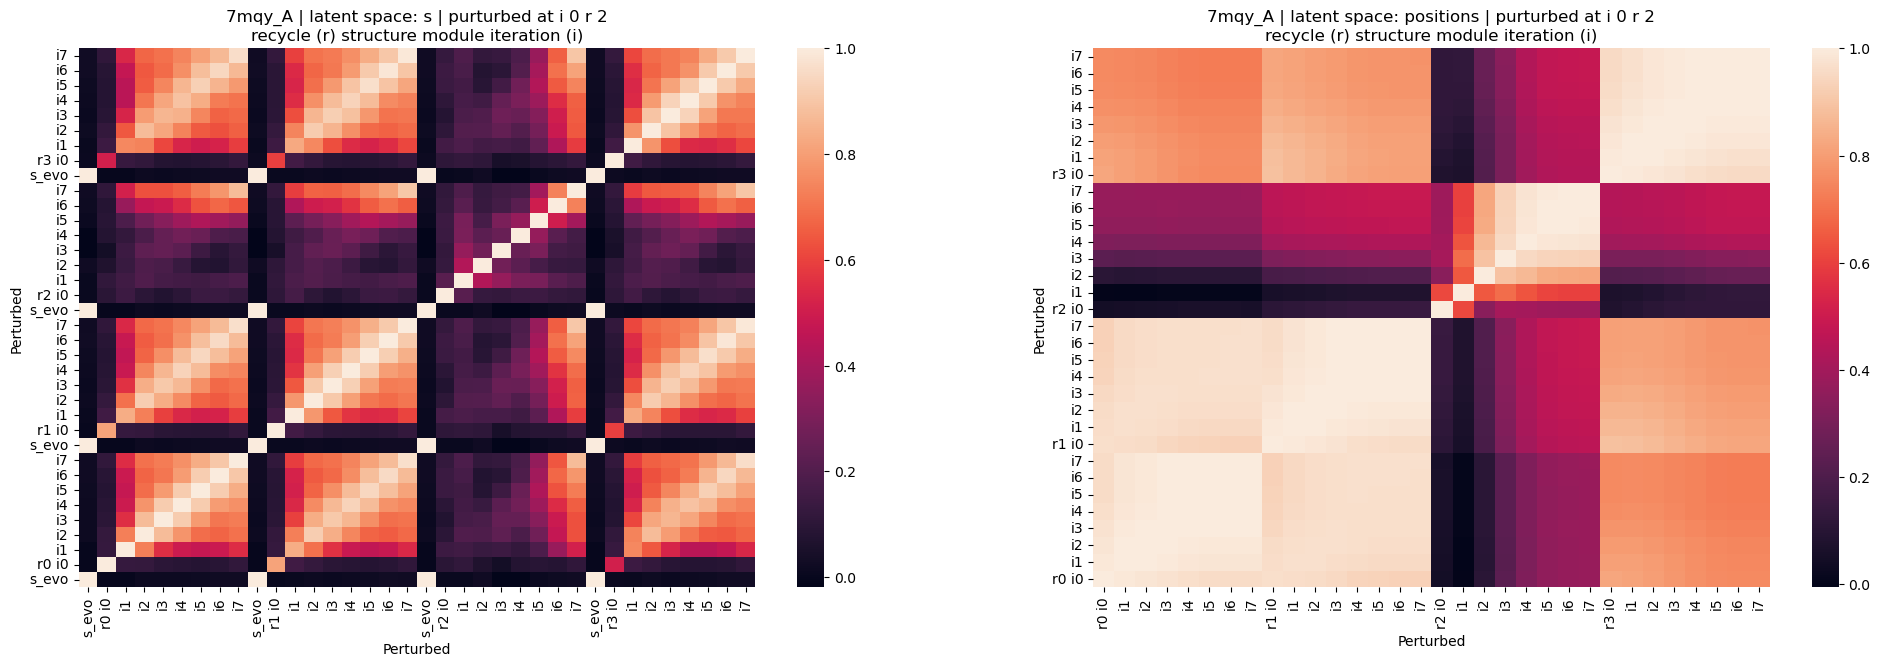

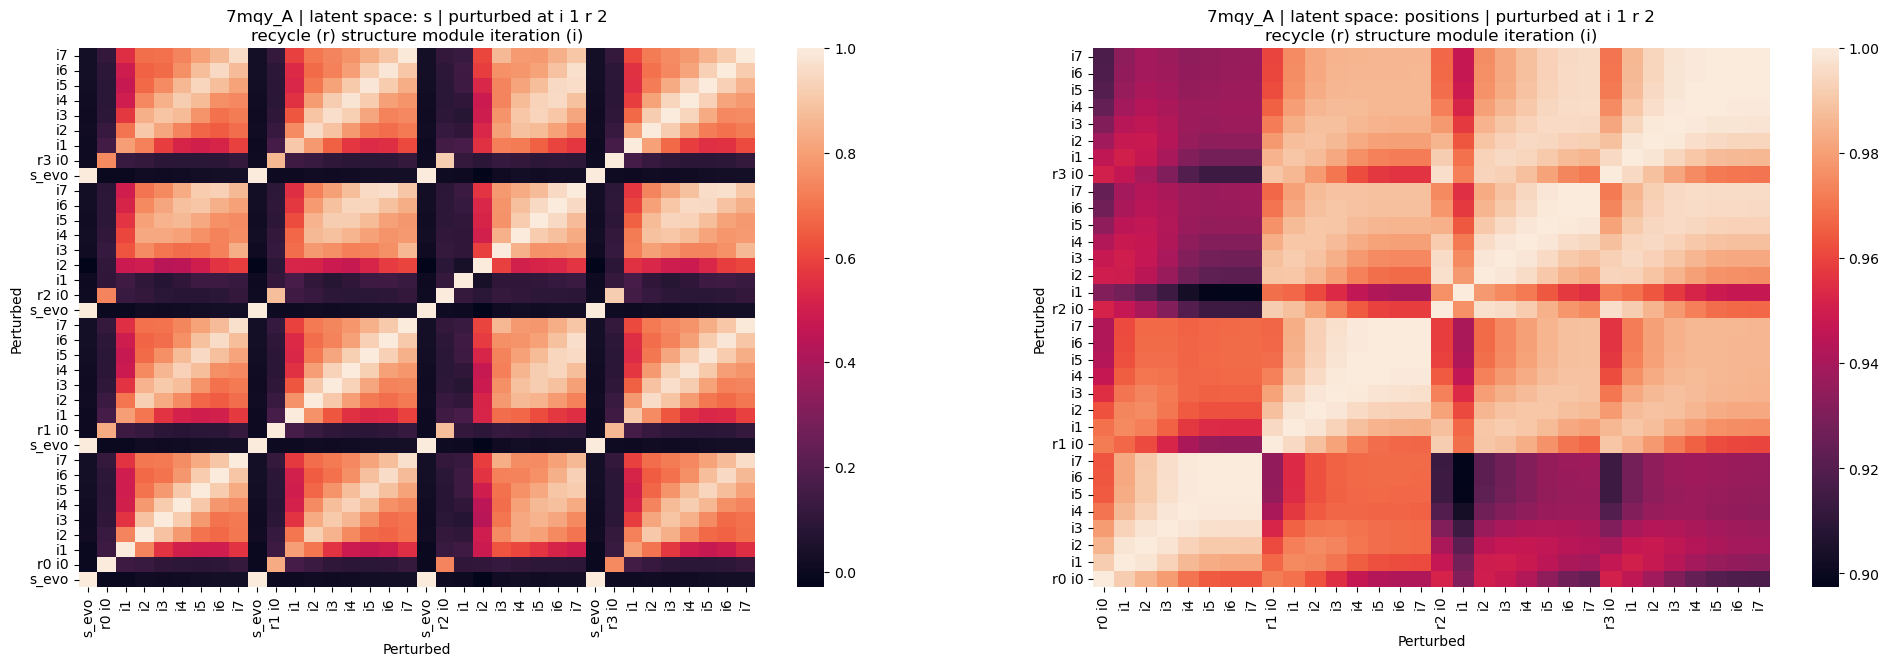

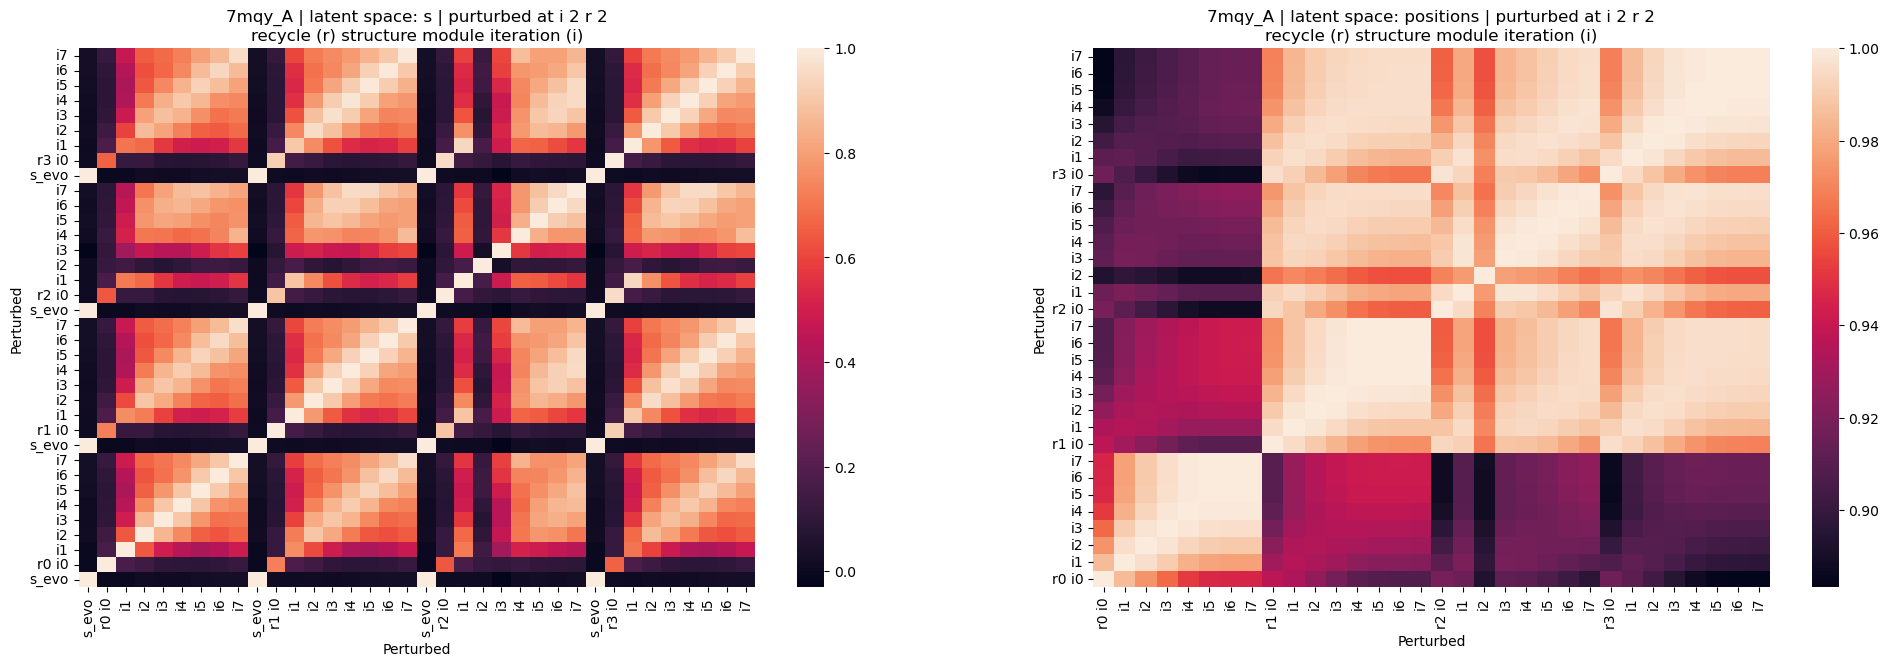

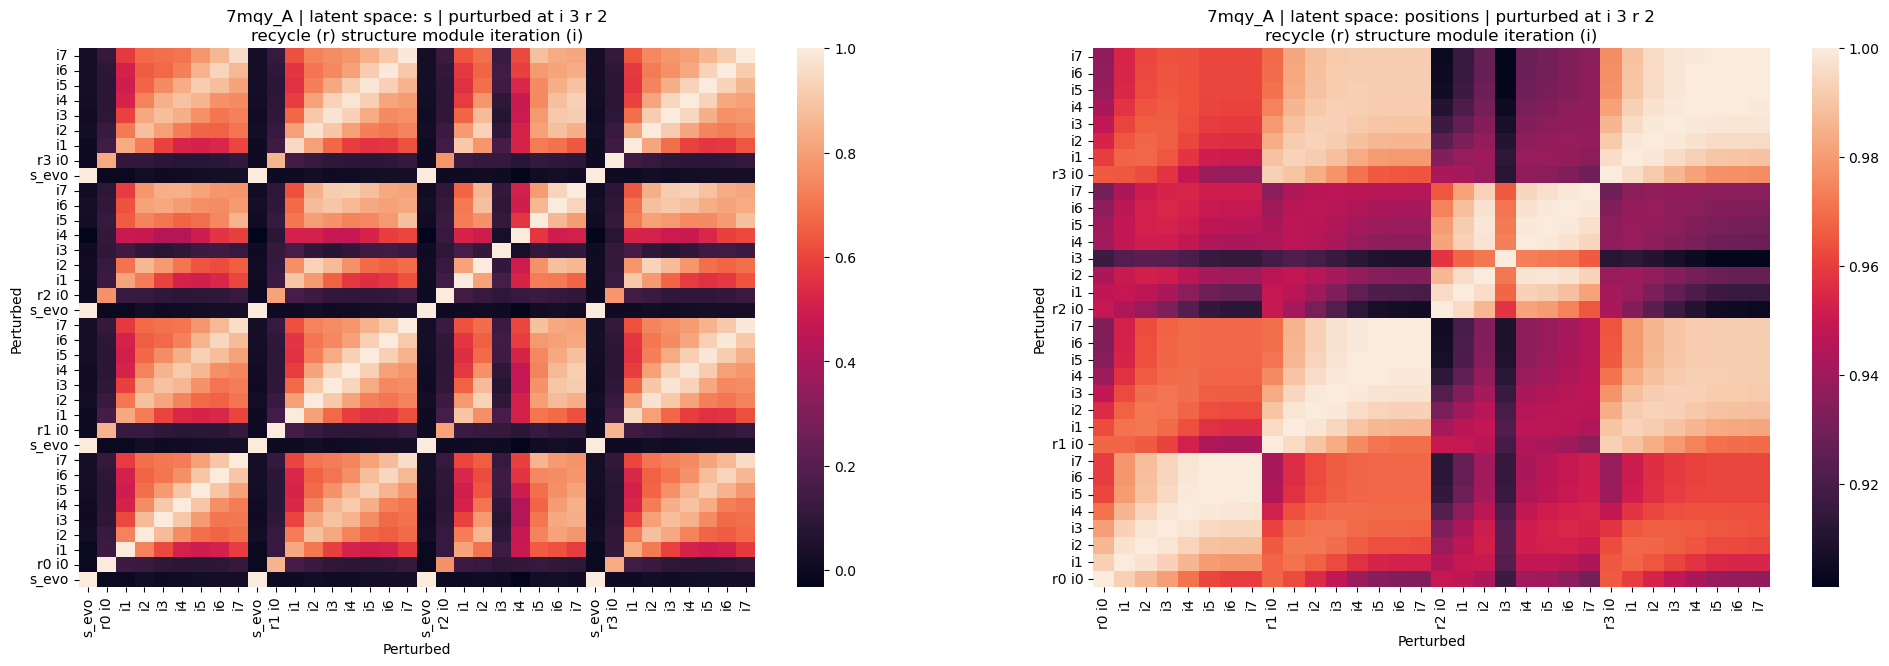

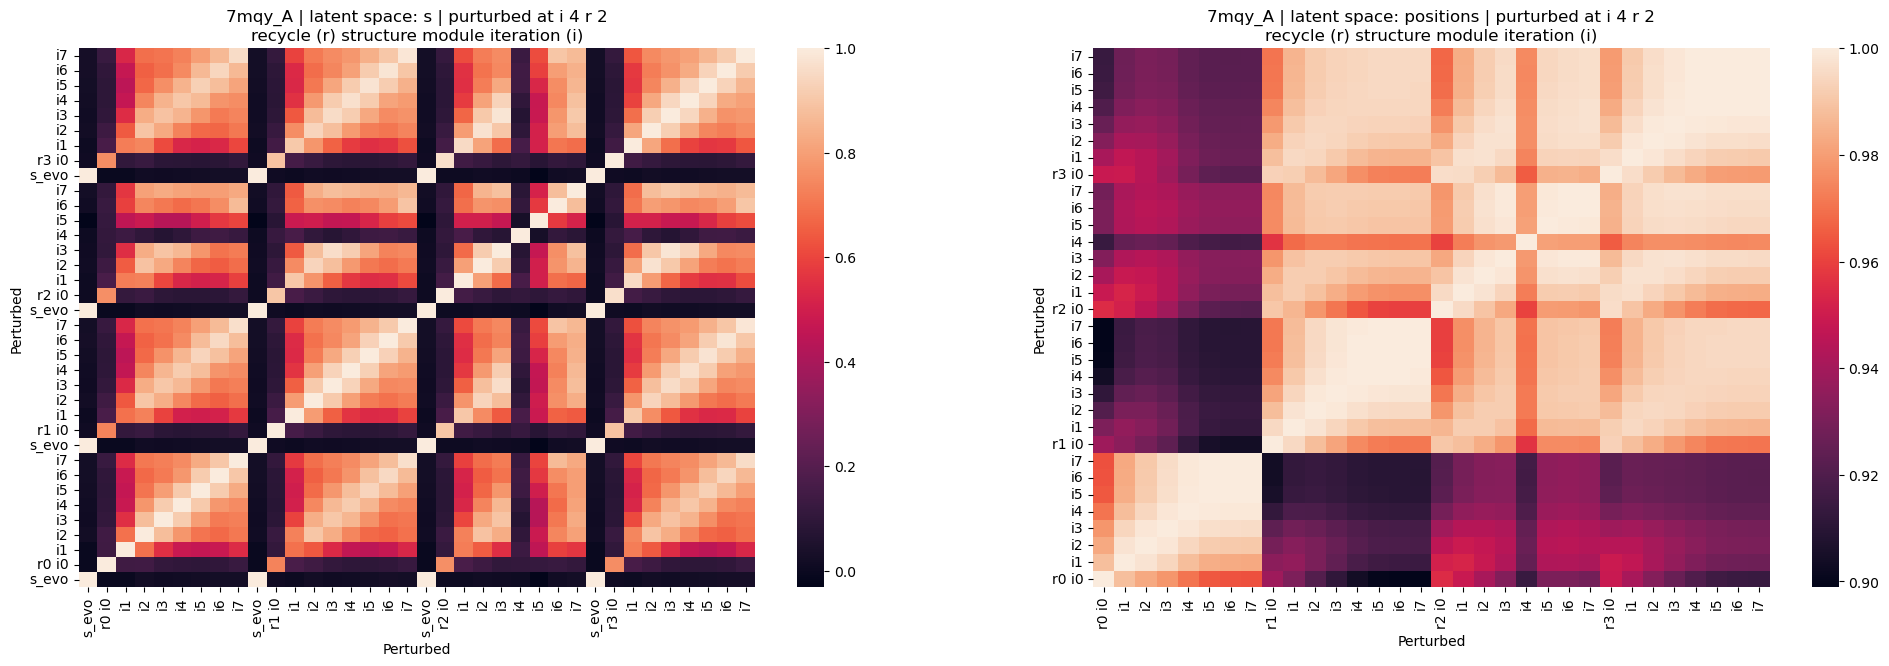

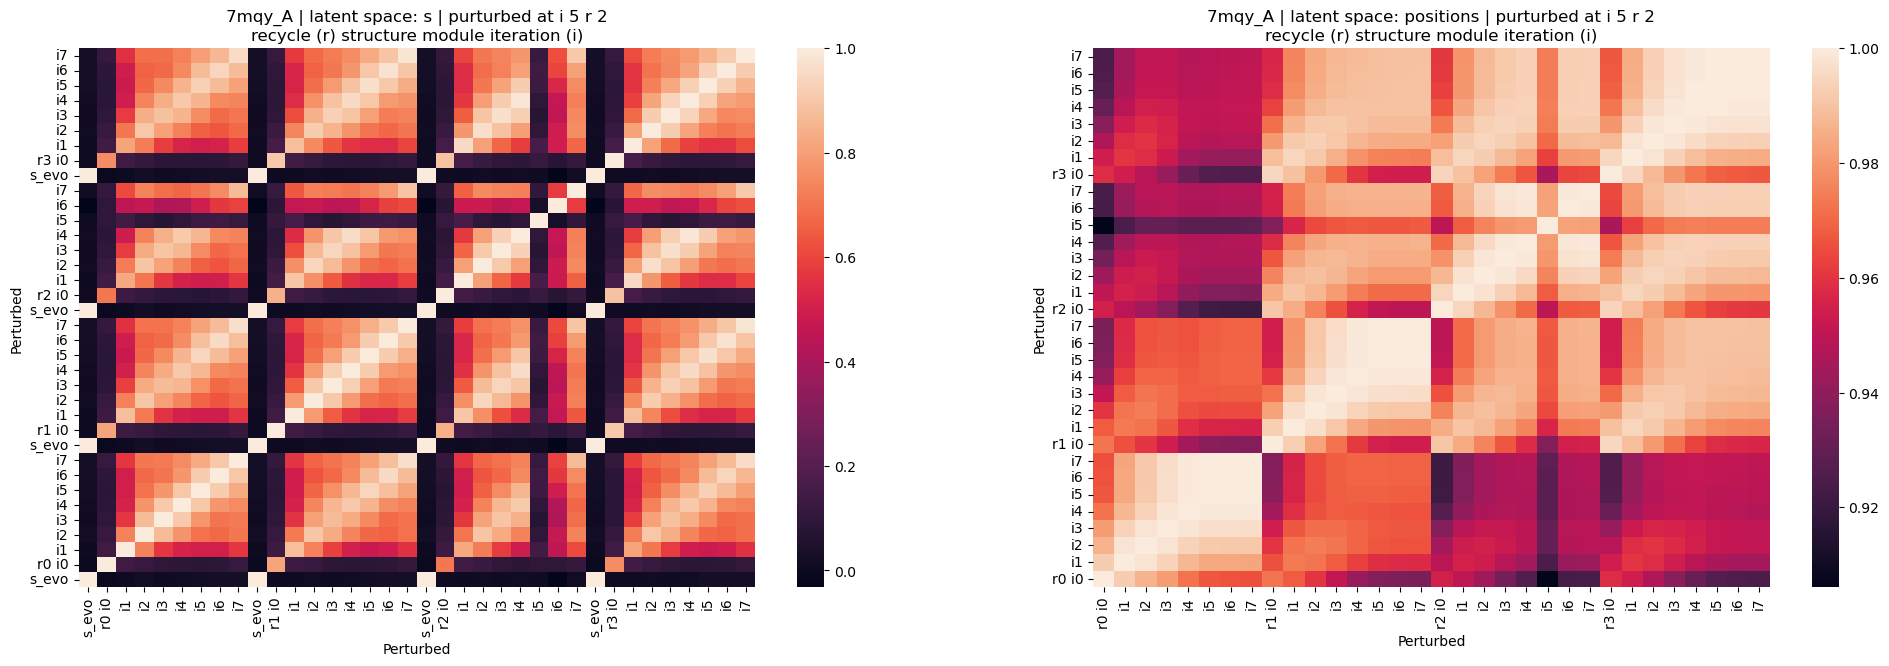

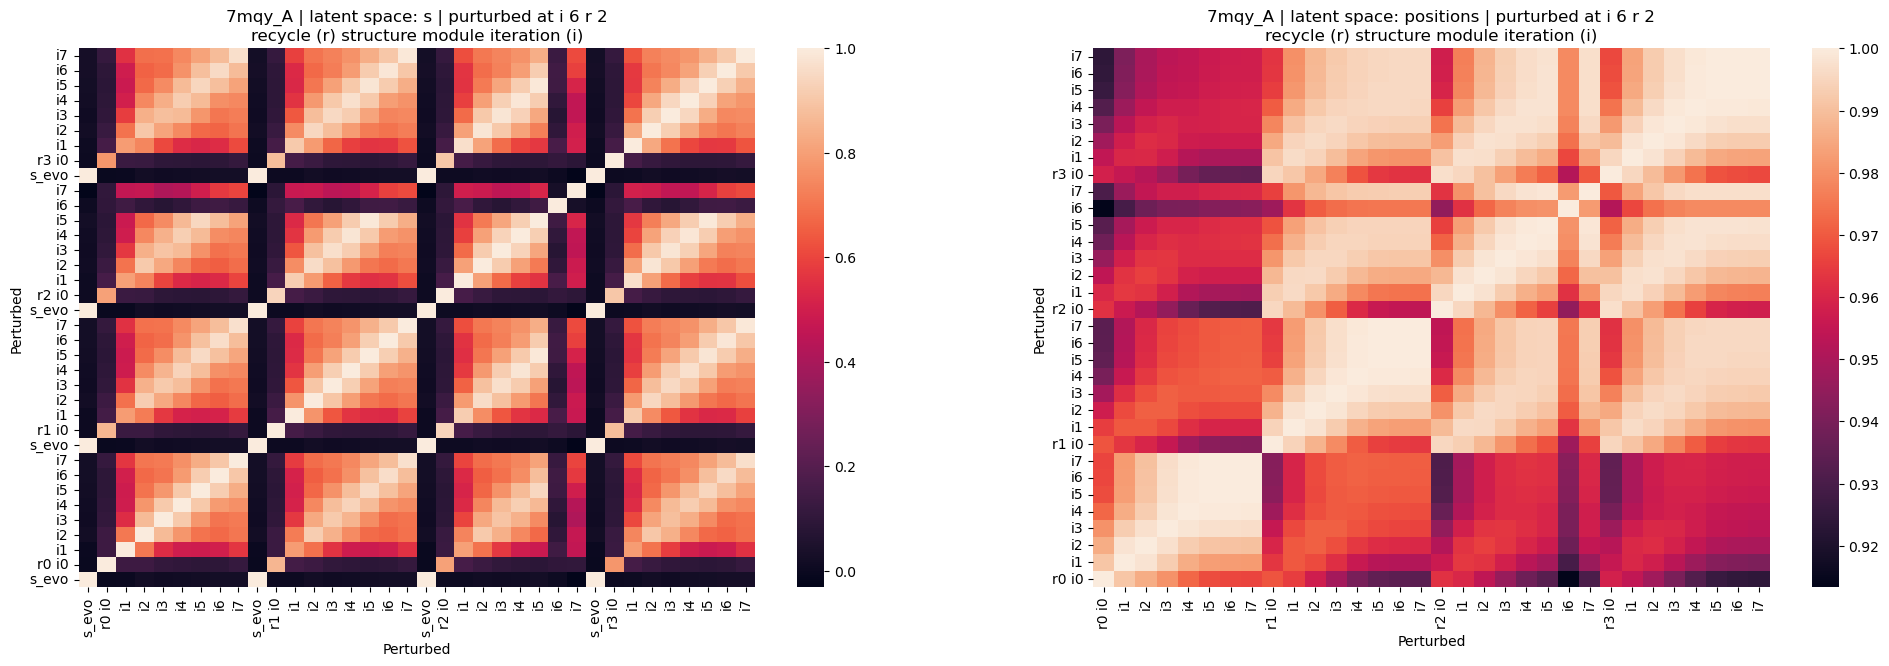

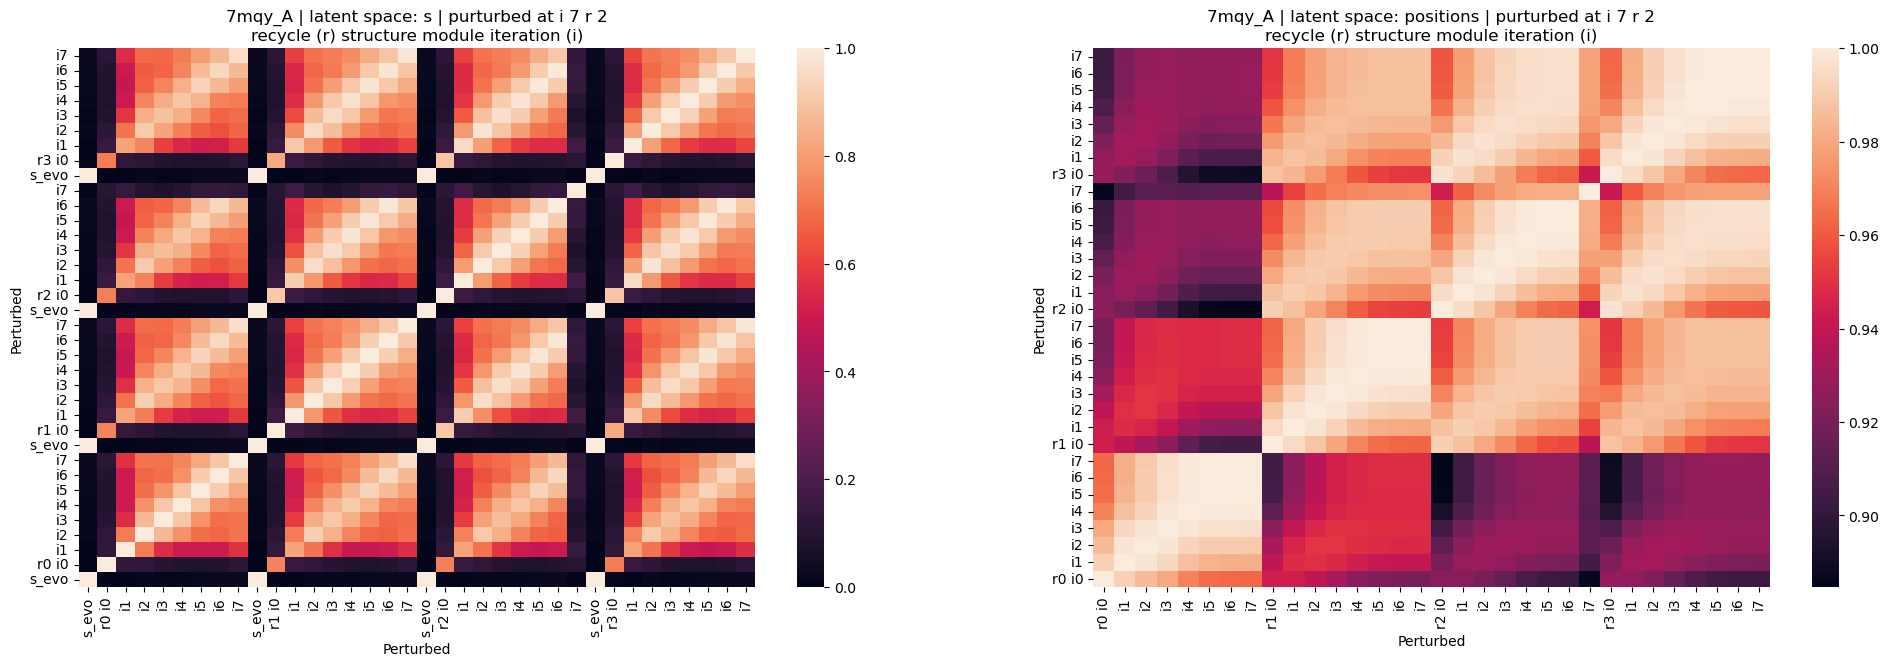

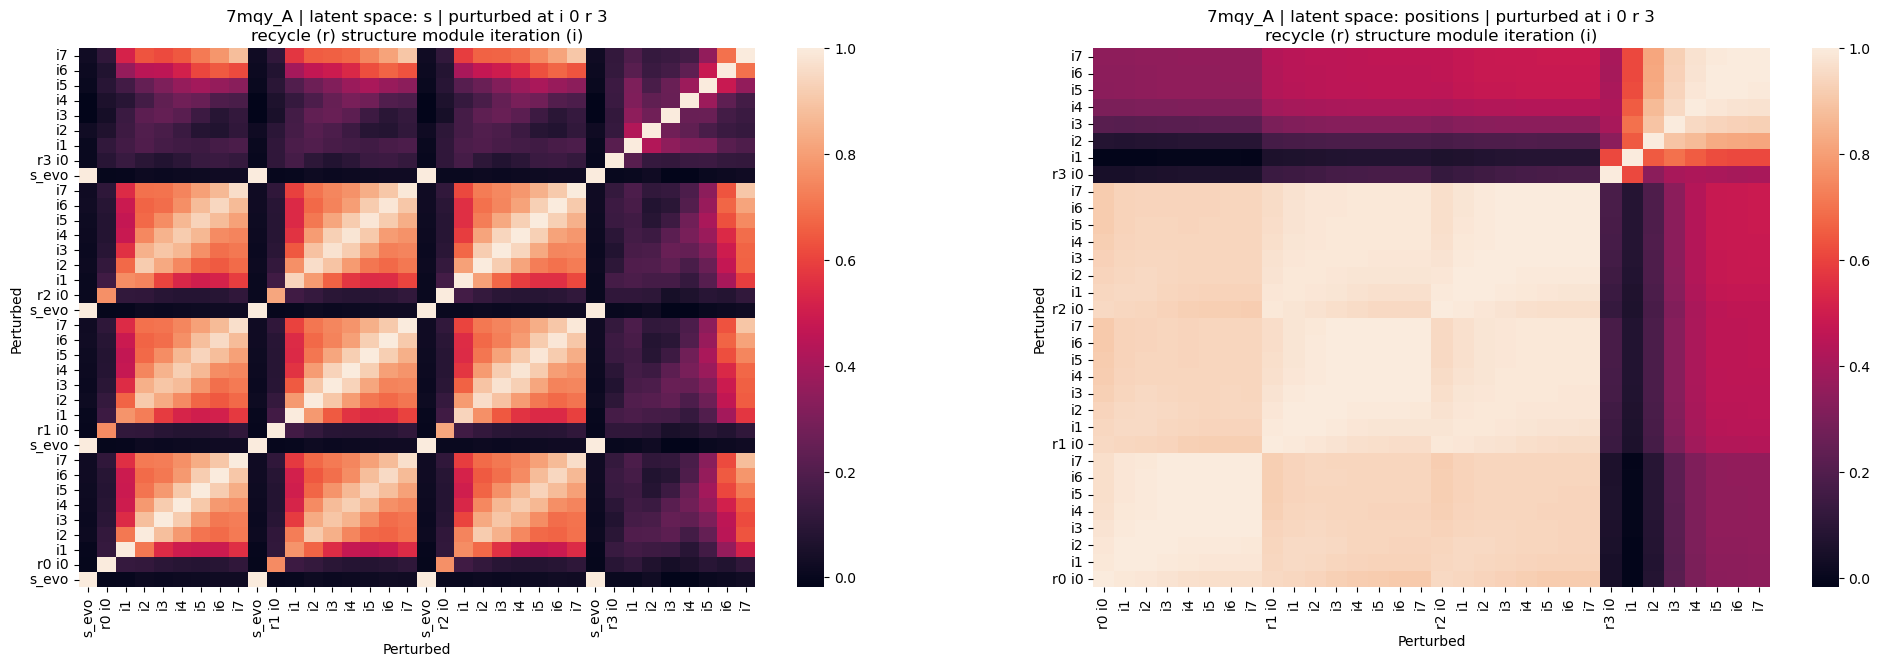

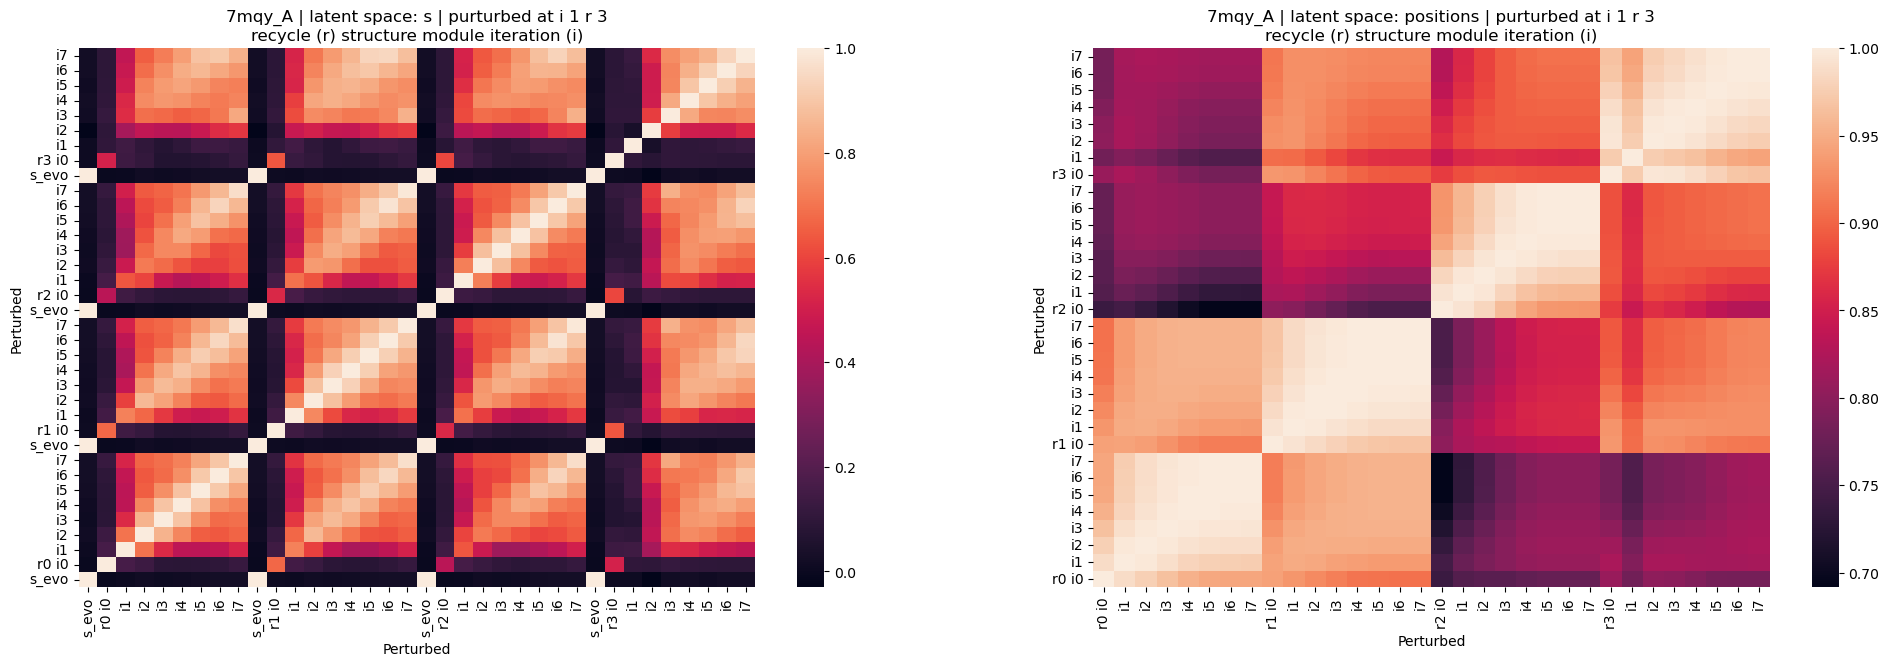

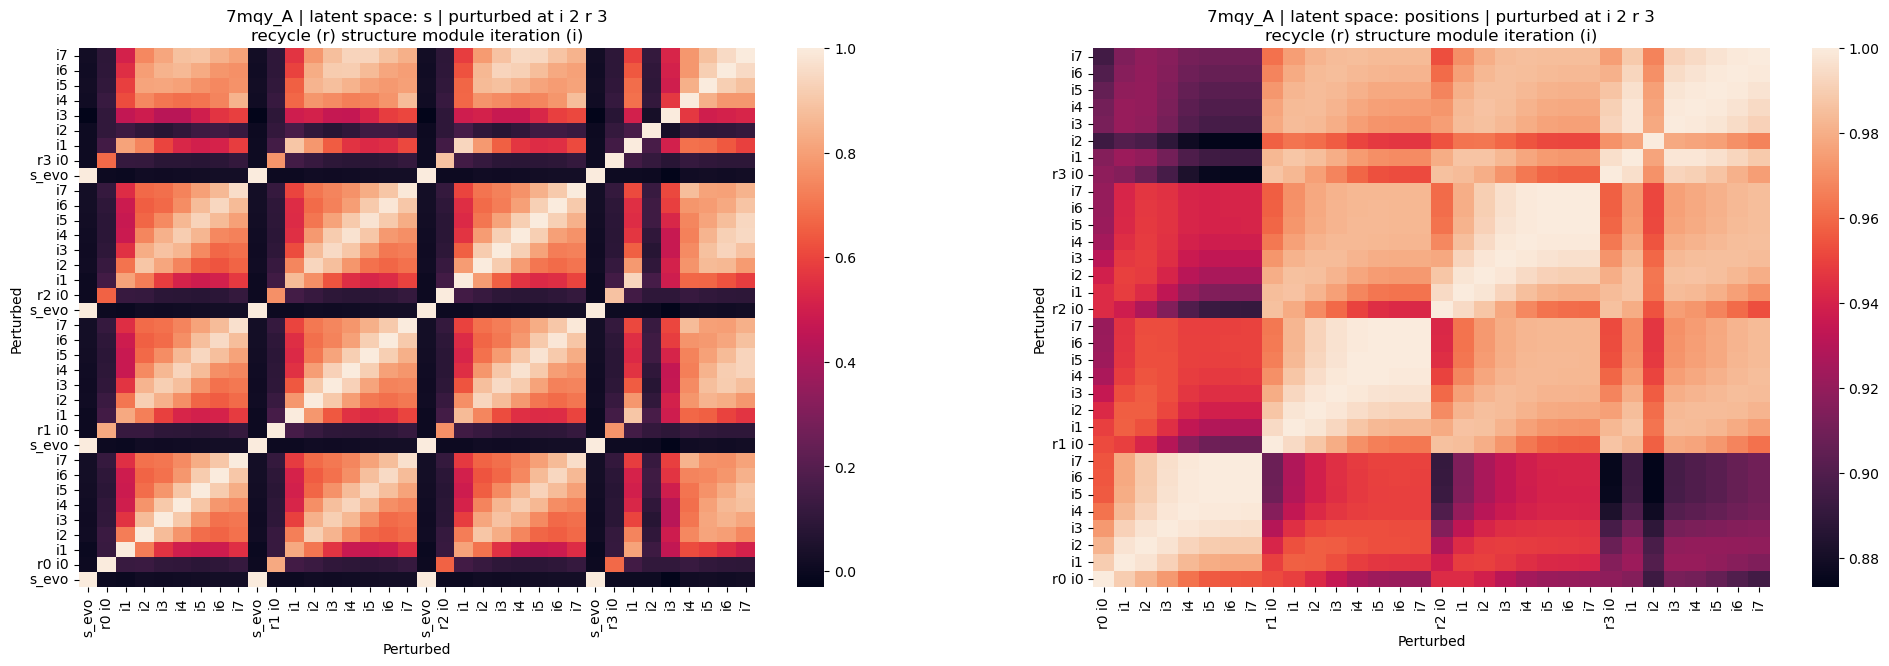

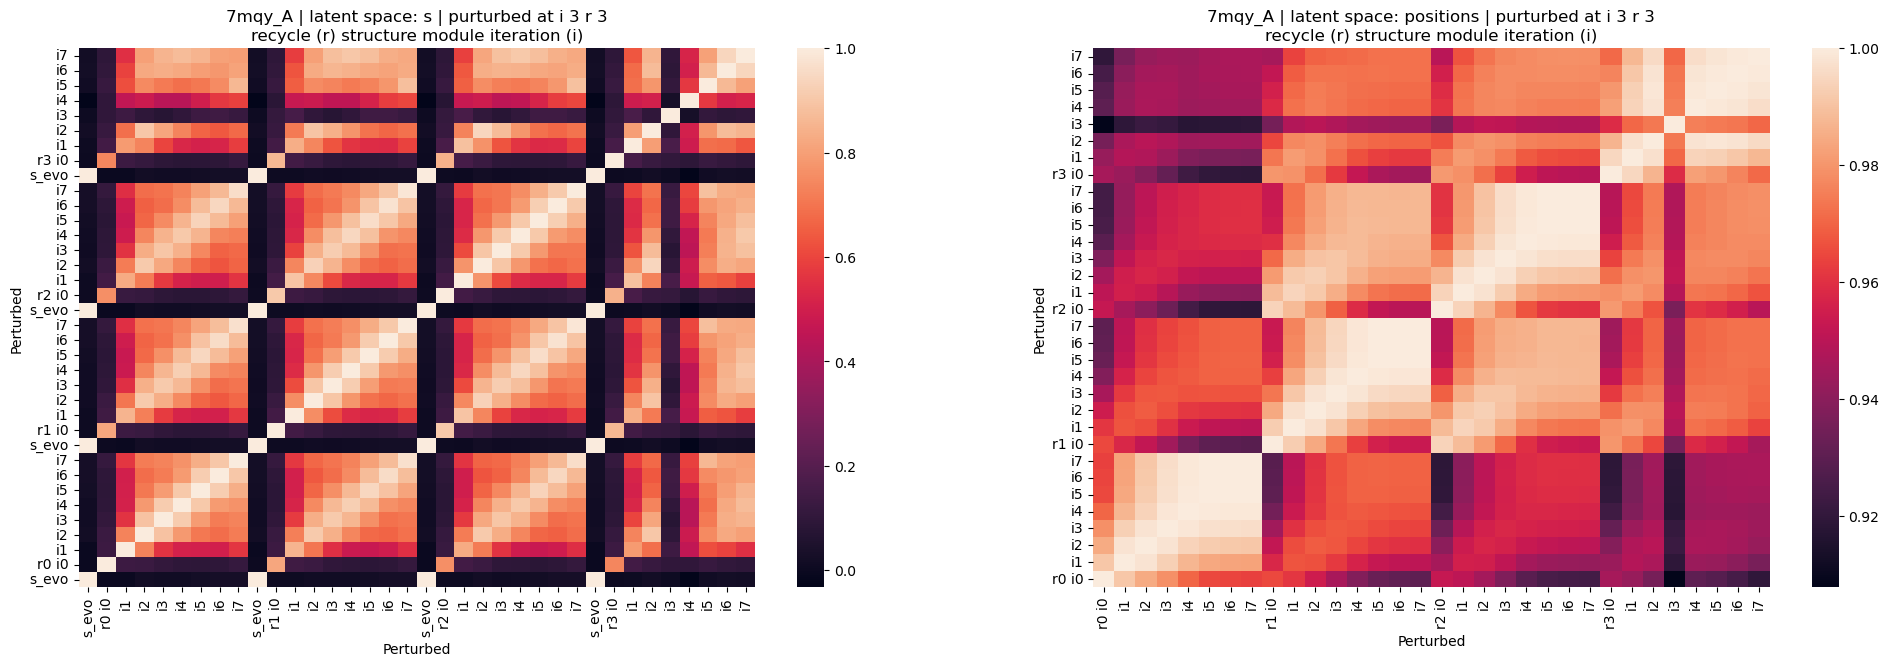

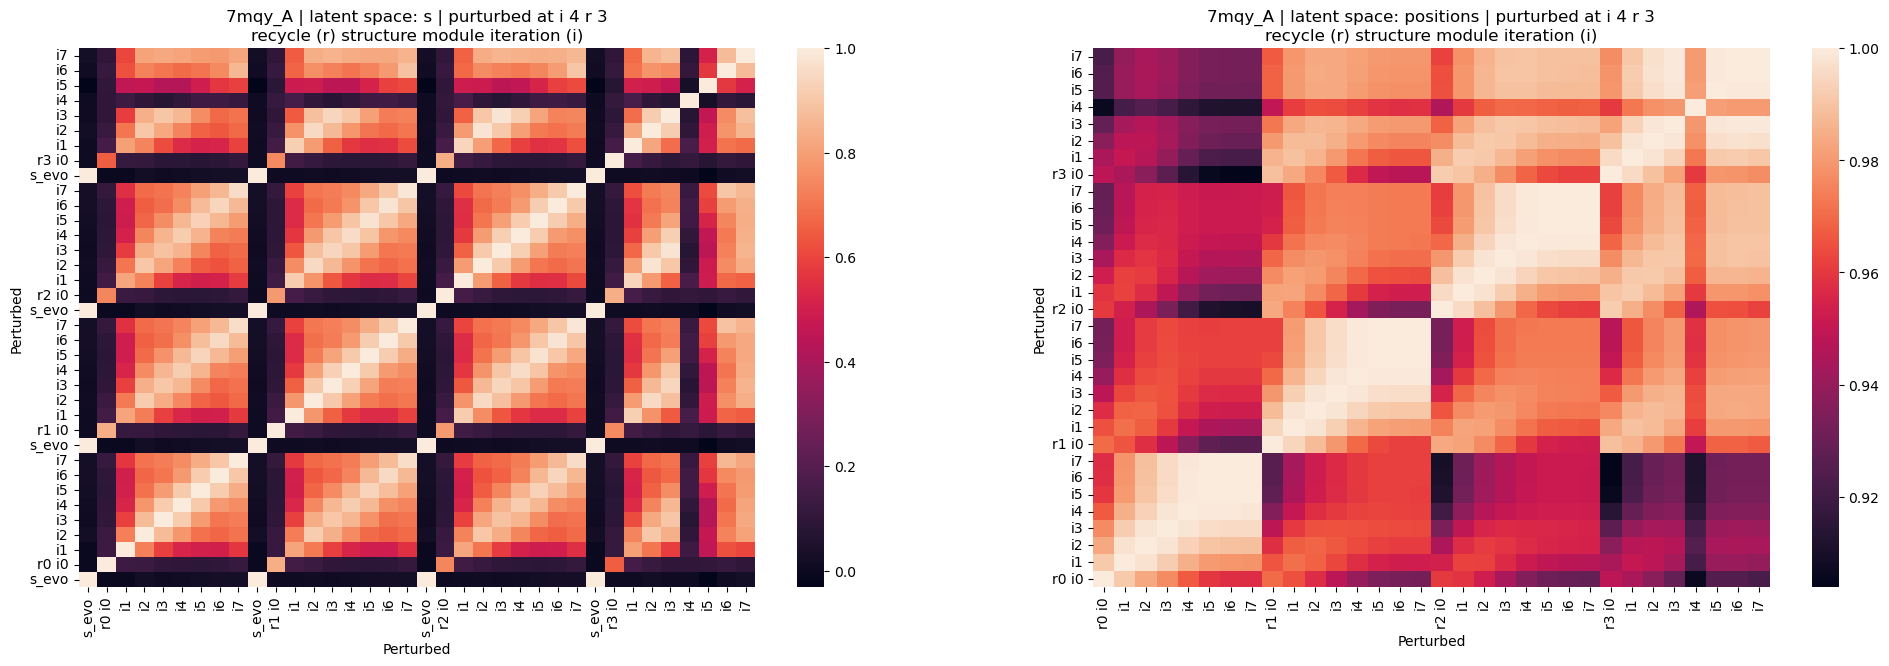

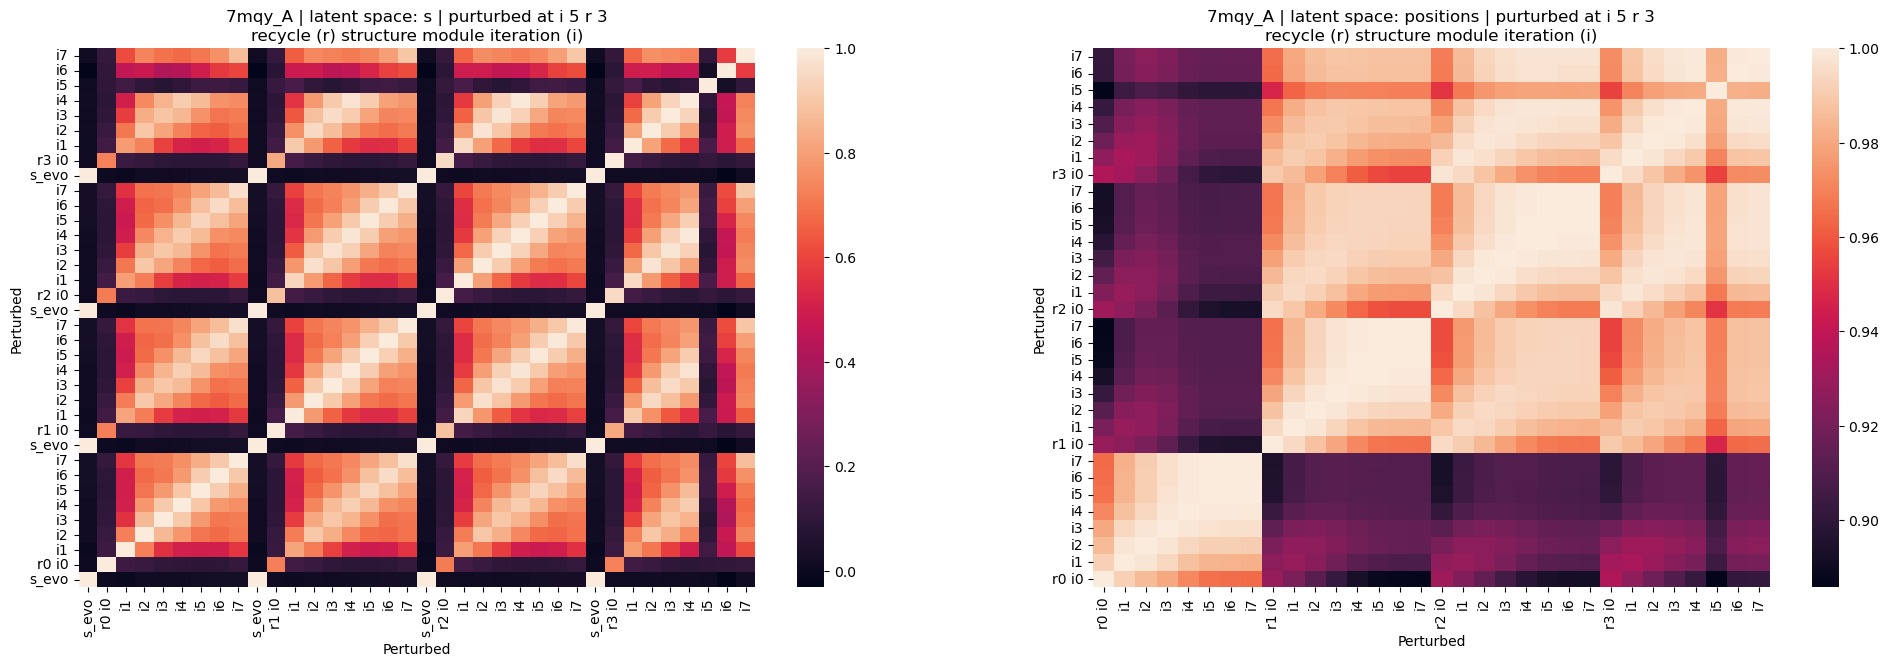

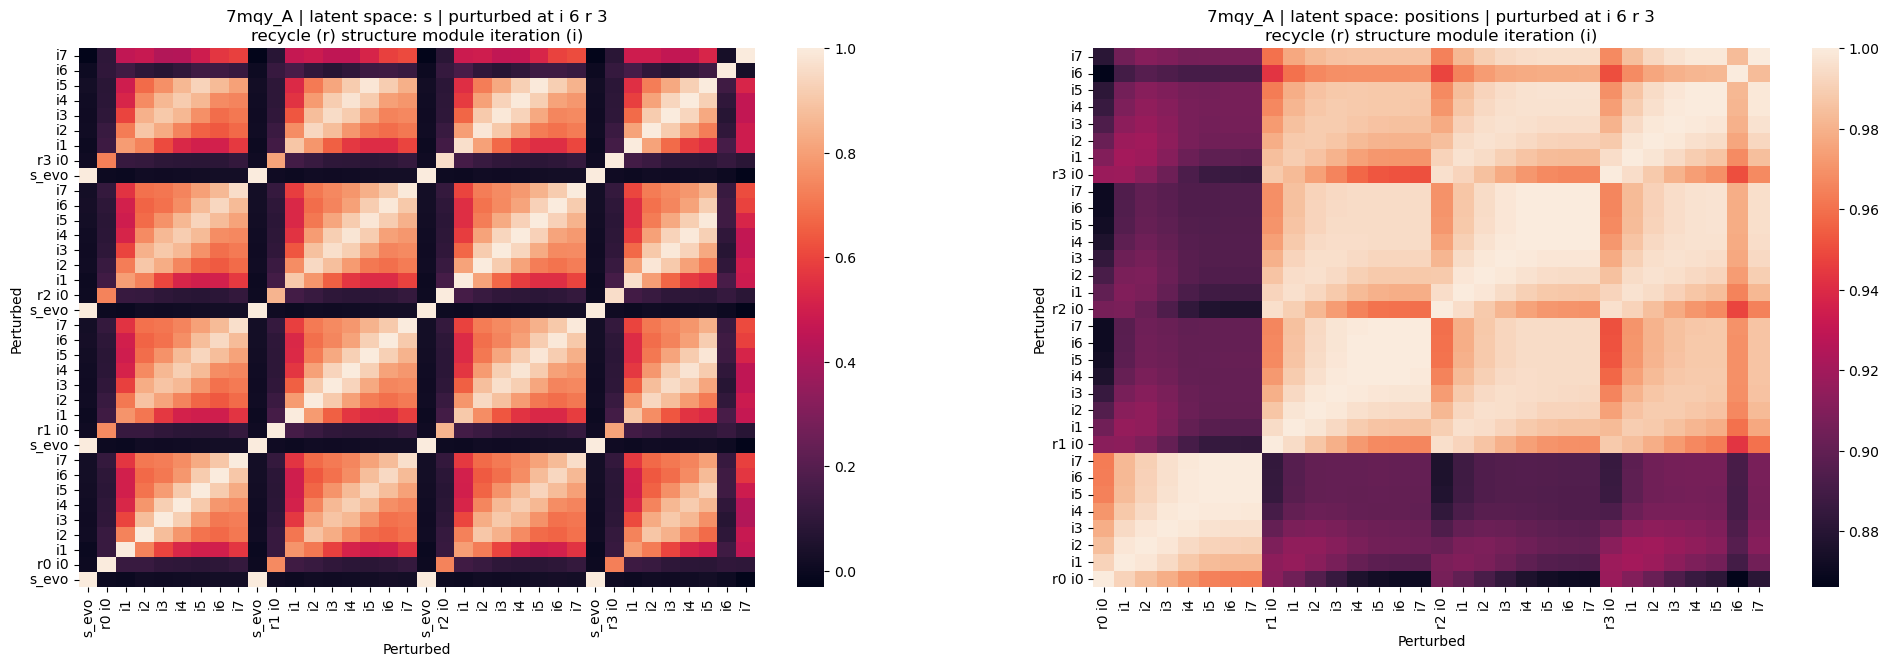

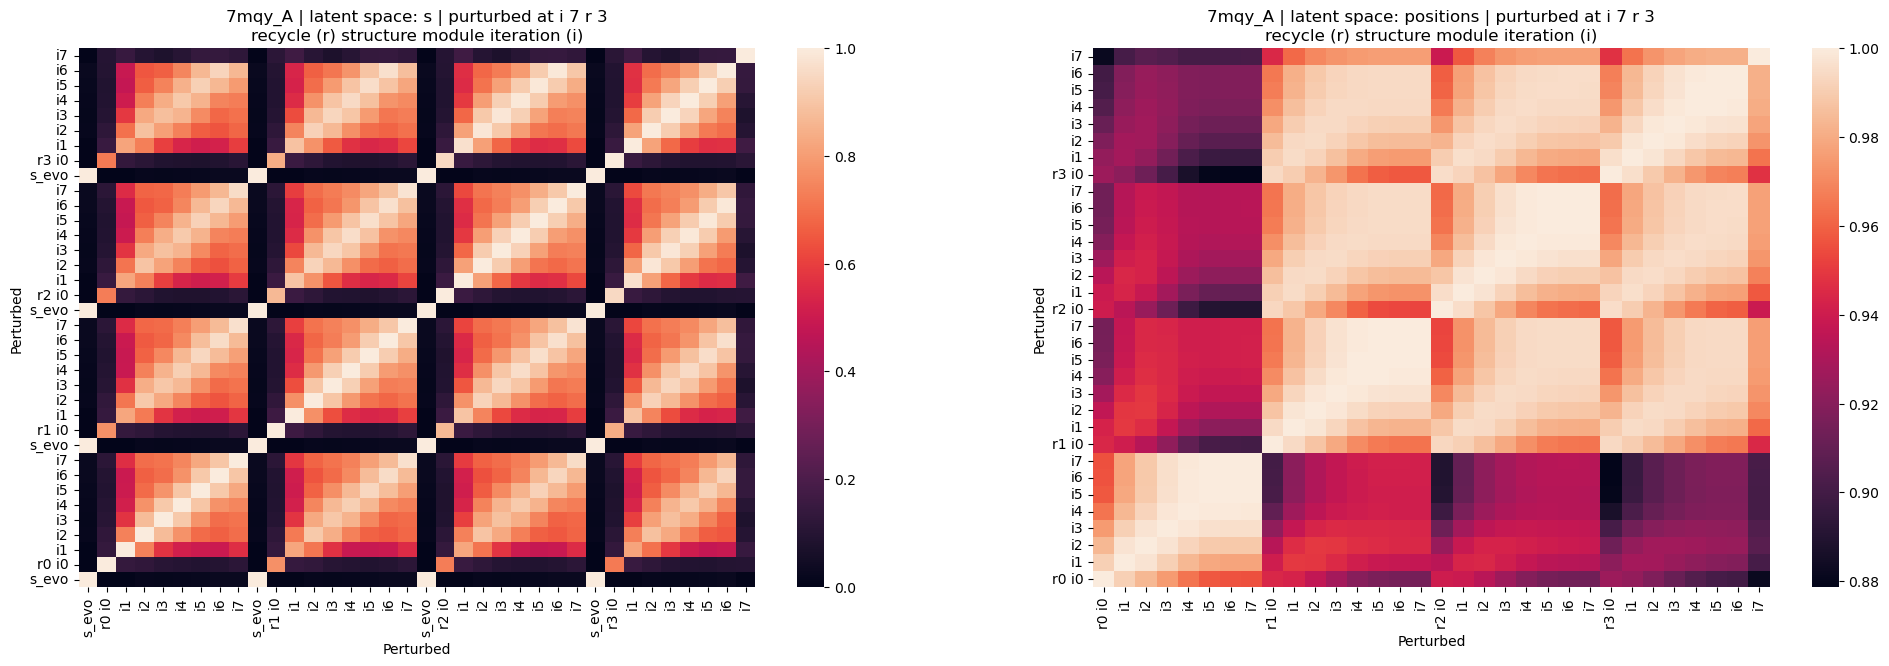

In [117]:
p = '7mqy_A' # 7tav_B 7t9w_B 7mqy_A 7bcz_A
plt.rcParams["figure.figsize"] = (7,5)
tmscore_barchart(p)
plt.show()
plt.rcParams["figure.figsize"] = (24,7)
plt.subplot(1,2,1)
latent_space_cosine_grid_DOE_with_evo_s(p,-1,-1)
plt.subplot(1,2,2)
latent_space_cosine_grid_DOE(p,'positions',-1,-1)
plt.show()
for r in range(4):
    for i in range(8):
        plt.subplot(1,2,1)
        latent_space_cosine_grid_DOE_with_evo_s(p,i,r)
        plt.subplot(1,2,2)
        latent_space_cosine_grid_DOE(p,'positions',i,r)
        plt.show()
        #plt.subplot(1,3,3)
        #heatmap_pert_vs_unpert(p,'positions',i,r)
        #plt.show()

7tav_B


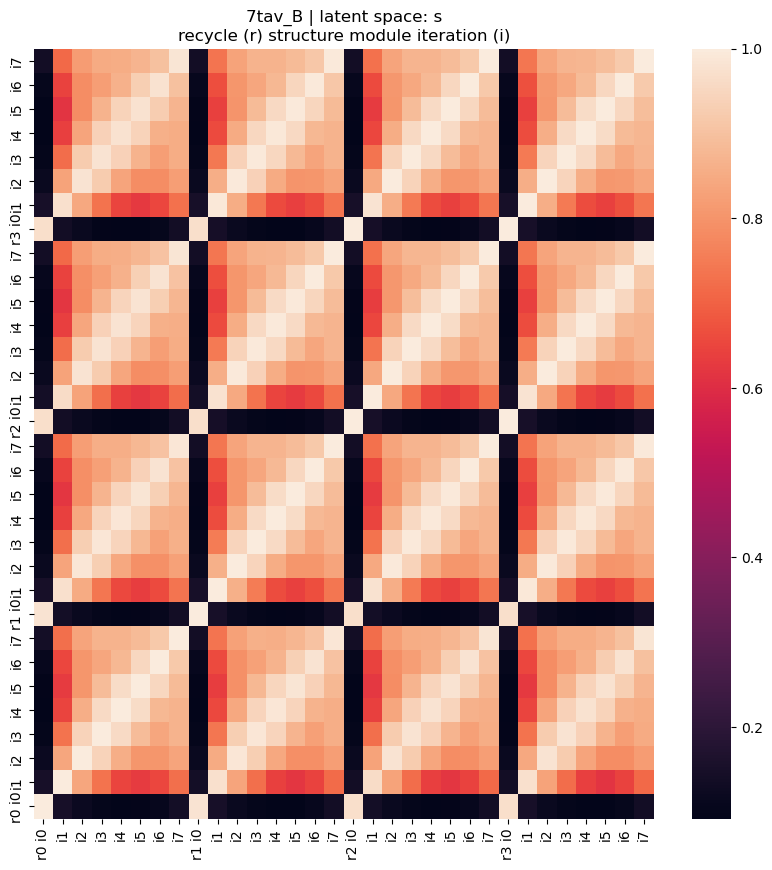

7eea_A


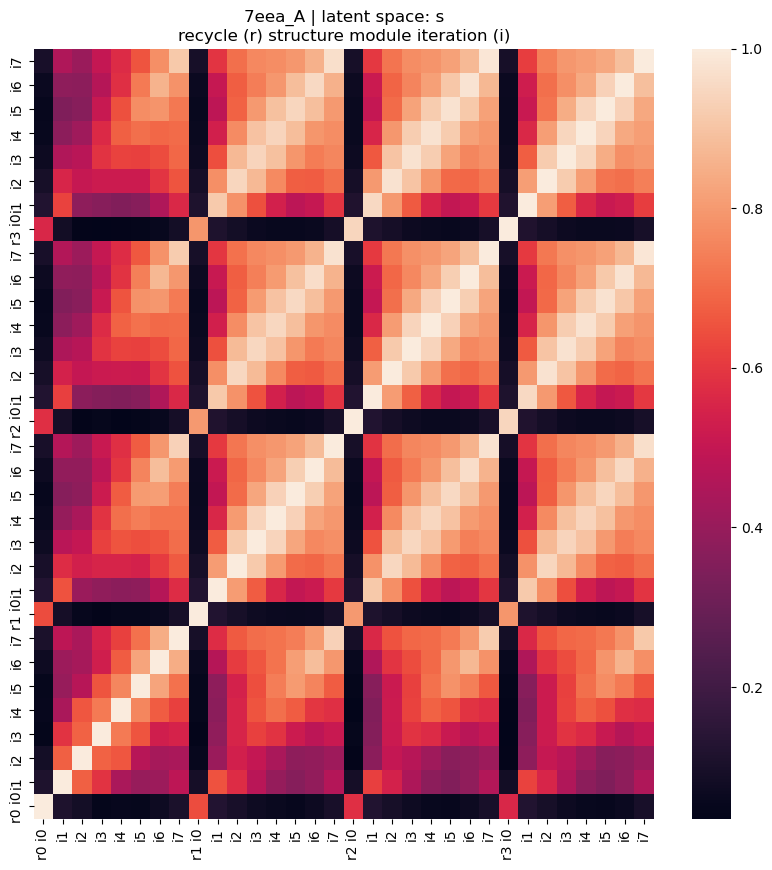

7bny_B


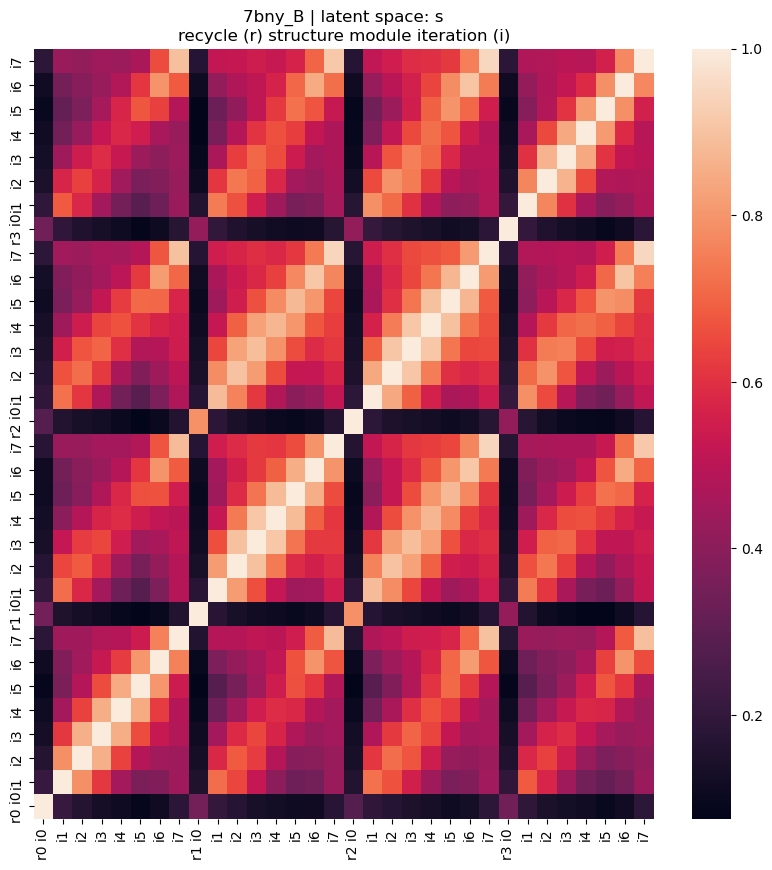

7dck_A


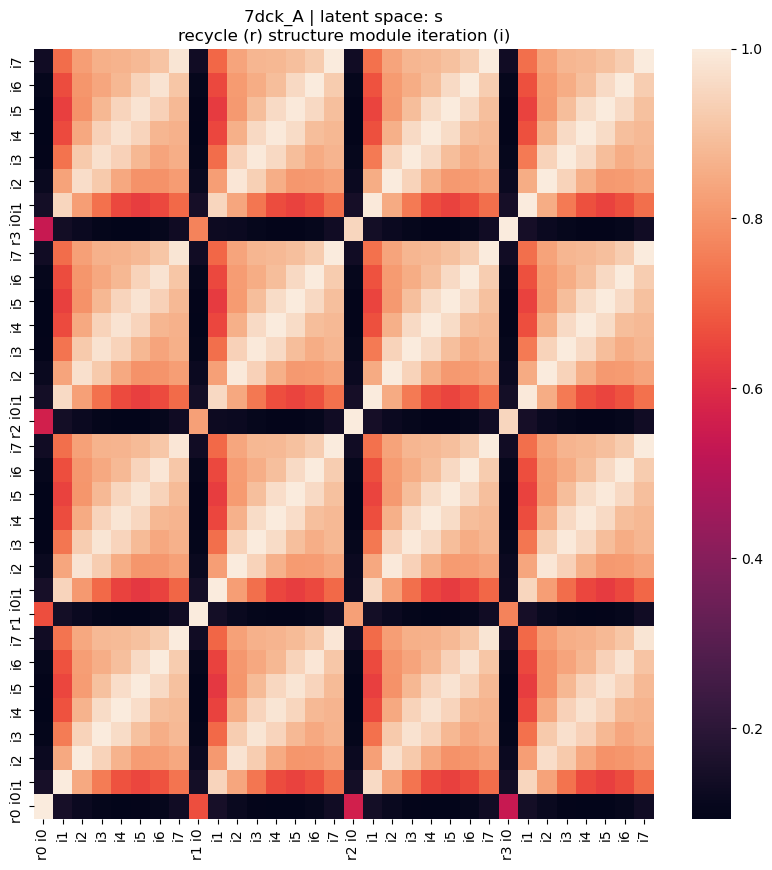

In [ ]:
# old code that didn't work. maybe useful for reference later

lst_iterations = [f"r{r}i{i}" for r in range(4) for i in range(8)]
lst_results = [np.ones(4)*i for i in range(32)]
df = pd.DataFrame({'a': lst_iterations,
                   'a_results': lst_results,
                   'b': lst_iterations,
                   'b_results': lst_results
                  })
df_pivot = df.pivot_table(values=['a_results', 'b_results'], index='a',columns='b',aggfunc=np.sum)
###
df = pd.DataFrame(columns=lst_iterations)#, index=lst_iterations)
for r in range(4):
    for i in range(8):
        df.loc[f"r{r}i{i}",f"r{r}i{i}"] = float(i+r)
df